# Define configurations

In [1]:
user = 'participant2'
frequency = '15min' # 15min | 15s
dataset_type = '' # ''

if frequency == '15min':
    record_size_per_day = 96
elif frequency == '15s':
    record_size_per_day = 5760

# Columns to include    
if dataset_type == '':
    columns = [ 'timestamp', 'heart_rate', 'steps', 'stress_score',
            'awake', 'deep', 'light', 'rem', 'nonrem_total', 'total', 'nonrem_percentage', 'sleep_efficiency',
            'time_from_last_drug_taken', 'wearing_off' ]

metrics = {
    'balanced_accuracy': 'Bal. Acc.',
    'f1_score': 'F1 Score',
    'accuracy': 'Acc.',
    'precision': 'Precision',
    'sensitivity': 'Recall / Sn',
    'specificity': 'Sp',
    'auc': 'AUC'
}

# Preparation

## Load libraries

In [2]:
from datetime import datetime
from datetime import timedelta
from typing import Union, Generator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import warnings
from sklearn.exceptions import UndefinedMetricWarning, ConvergenceWarning

import sklearn
from photonai.base import Hyperpipe, PipelineElement, Stack, Switch
from photonai.optimization import FloatRange, IntegerRange, Categorical, BooleanSwitch, PhotonHyperparam
from photonai.optimization import Categorical as PhotonCategorical
from photonai.optimization import MinimumPerformanceConstraint, DummyPerformanceConstraint, BestPerformanceConstraint
from photonai.optimization.base_optimizer import PhotonSlaveOptimizer
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

from skopt import Optimizer
from skopt.space import Real, Integer, Dimension
from skopt.space import Categorical as skoptCategorical
from photonai.photonlogger.logger import logger
from photonai.optimization.scikit_optimize.sk_opt import SkOptOptimizer

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=Warning)
from photonai.base import Hyperpipe
from photonai.optimization import MinimumPerformanceConstraint
from photonai.photonlogger import logger 

## Load combined data

In [3]:
combined_data = pd.read_excel(f'./data/combined_data/{dataset_type}combined_data_{user}_{frequency}.xlsx',
                              index_col="timestamp",
                              usecols=columns,
                              engine='openpyxl')
if dataset_type == '':
    y = combined_data.loc[:, combined_data.columns == 'wearing_off'].values[:,0]
    X = combined_data.loc[:, columns[1:-1]]

## Define Functions

In [4]:
# Show feature importances
def print_feature_importances(pipeline):
    output = ''
    if pipeline.optimum_pipe.feature_importances_ is None:
        output = 'Best Hyperparameter Configuration is a non-linear SVM, thus feature importances cannot be retrieved'
    else:
        output = 'Feature Importances using the Best Hyperparameter Config'
        if not [value.base_element.support_.tolist() for key, value in pipeline.optimum_pipe.elements if key == 'RFE']:
            if len(pipeline.optimum_pipe.feature_importances_) == 1:
                feature_importances = pipeline.optimum_pipe.feature_importances_[0]
            else:
                feature_importances = pipeline.optimum_pipe.feature_importances_
            output += '\n'
            output += tabulate(
                pd.DataFrame(
                    [np.around(feature_importances, decimals=4)],
                    columns=np.array(columns[1:-1])
                ).transpose().sort_values(by=[0], ascending=False, key=abs),
                tablefmt='psql', floatfmt=".4f", headers=['Features', 'Values']
            )
        else:
            mask = [value.base_element.support_.tolist() for key, value in pipeline.optimum_pipe.elements if key == 'RFE'][0]
            if len(pipeline.optimum_pipe.feature_importances_) == 1:
                feature_importances = pipeline.optimum_pipe.feature_importances_[0]
            else:
                feature_importances = pipeline.optimum_pipe.feature_importances_
            output += '\n'
            output += tabulate(
                pd.DataFrame(
                    [np.around(feature_importances, decimals=4)],
                    columns=np.array(columns[1:-1])[mask]
                ).transpose().sort_values(by=[0], ascending=False, key=abs),
                tablefmt='psql', floatfmt=".4f", headers=['Features', 'Values']
            )
    return output

In [5]:
def plot_cv_indices(cv, X, y, ax, n_splits=0, lw=20):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                    c=indices, marker='_', lw=lw, cmap=plt.cm.coolwarm,
                    vmin=-.2, vmax=1.2)

    n_splits = ii + 1

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X), c=y, marker='_', lw=lw, cmap=plt.cm.Paired)

    # Formatting
    yticklabels = list(range(n_splits)) + ['wearing-off']
    ax.set(yticks=np.arange(n_splits+1) + .5, yticklabels=yticklabels,
           xlabel='Records\'s Index', ylabel="Folds",
           ylim=[n_splits+1.2, -.2], xlim=[0, len(X)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax


In [6]:
def plot_confusion_matrix_from_pipeline(pipeline):
    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(
        pipeline.results_handler.get_test_predictions()['y_true'],
        pipeline.results_handler.get_test_predictions()['y_pred'],
        labels=[0,1], normalize=None)
    ax = plt.subplot()
    sns.set(font_scale=3.0) # Adjust to fit
    sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g");  

    # Labels, title and ticks
    label_font = {'size':'25'}  # Adjust to fit
    ax.set_xlabel('Predicted labels', fontdict=label_font);
    ax.set_ylabel('Observed labels', fontdict=label_font);

    # title_font = {'size':'21'}  # Adjust to fit
    # ax.set_title('Confusion Matrix', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=25)  # Adjust to fit
    ax.xaxis.set_ticklabels(['Good', 'Wearing-Off']);
    ax.yaxis.set_ticklabels(['Good', 'Wearing-Off']);
    plt.rc('text') # , usetex=False)
    plt.rc('font', family='serif')
    # plt.savefig('./participant2-downsampling-confusionmatrix-real.pdf', bbox_inches='tight')
    plt.show()

In [7]:
# Write other reports to summary file
def add_other_report_to_summary(pipeline, with_estimator_comparison=True):
    with open(f'{pipeline.output_settings.results_folder}/photon_summary.txt', "a+") as summary_file:
        # 1. Write comparison of learning algorithms
        if with_estimator_comparison:
            summary_file.write("\n\n")
            summary_file.write("Comparison on learning algorithms on validation set")
            summary_file.write("\n")
            summary_file.write(str(pipeline.results_handler.get_mean_of_best_validation_configs_per_estimator()))

        # 2. Write feature importance
        summary_file.write("\n\n")
        summary_file.write("Feature Importance")
        summary_file.write(print_feature_importances(pipeline))
        
        # 3. Write beautified average test performance across outer folds
        # a. Get Average Test Performance Across Outer Folds
        test_metric_result = pipeline.results.get_test_metric_dict()
        
        # b. Replace display metric name
        #   Reference: https://stackoverflow.com/a/55250496/2303766
        test_metric_result = { metrics[metric]: test_metric_result[metric]
                                  for metric, metric_name in metrics.items() if metric in test_metric_result
                             }
        
        # c. Add beautified average test performance across outer folds to file 
        summary_file.write("\n\n")
        summary_file.write("Average Test Performance Across Outer Folds")
        summary_file.write("\n")
        summary_file.write(
            tabulate(
                pd.DataFrame(
                    test_metric_result
                ).round(4).transpose(),
                tablefmt='psql', floatfmt=".4f", headers='keys'
            )
        )
        
        # 4. Write outer fold results
        summary_file.write("\n\n")
        summary_file.write("Outer Fold Best Estimators' Performance")
        summary_file.write("\n")
        handler = pipeline.results_handler
        performance_table = handler.get_performance_table()
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            summary_file.write(
                tabulate(
                    performance_table.loc[:, ['fold', 'best_config', 'n_train', 'n_validation']].transpose(),
                    tablefmt='psql', headers='keys'
                )
            )
            summary_file.write("\n")
            summary_file.write(
                tabulate(
                    performance_table.loc[:, ['fold'] + list(metrics.keys())].round(4).transpose(),
                    tablefmt='psql', floatfmt=".4f", headers='keys'
                )
            )
            
        outer_fold_performance = {}
        config_evals = handler.get_config_evaluations()
        for metric in metrics.keys():
            # print(f'{metric}')
            for i, j in enumerate(config_evals[metric]):
                if f'{metric}_mean' in outer_fold_performance:
                    # outer_fold_performance[f'{metric}_max'].append(np.max(j))
                    outer_fold_performance[f'{metric}_mean'].append(np.mean(j))
                    outer_fold_performance[f'{metric}_std'].append(np.std(j))
                else:
                    # outer_fold_performance[f'{metric}_max'] = [np.max(j)]
                    outer_fold_performance[f'{metric}_mean'] = [np.mean(j)]
                    outer_fold_performance[f'{metric}_std'] = [np.std(j)]
        summary_file.write("\n")
        summary_file.write(
            tabulate(
                pd.DataFrame(outer_fold_performance).round(4).transpose(),
                tablefmt='psql', floatfmt=".4f", headers='keys'
            )
        )

In [8]:
# PhotonAI Optimize Monkey-patch
#     Added random_state for Optimize for result replicability
def prepare(self, pipeline_elements: list, maximize_metric: bool) -> None:
    """
    Initializes hyperparameter search with scikit-optimize.

    Assembles all hyperparameters of the list of PipelineElements
    in order to prepare the hyperparameter space.
    Hyperparameters can be accessed via pipe_element.hyperparameters.

    Parameters:
        pipeline_elements:
            List of all PipelineElements to create the hyperparameter space.

        maximize_metric:
            Boolean to distinguish between score and error.

    """
    self.start_time = None
    self.optimizer = None
    self.hyperparameter_list = []
    self.maximize_metric = maximize_metric

    # build skopt space
    space = []
    for pipe_element in pipeline_elements:
        if pipe_element.__class__.__name__ == 'Switch':
            error_msg = 'Scikit-Optimize cannot operate in the specified hyperparameter space with a Switch ' \
                        'element. We recommend the use of SMAC.'
            logger.error(error_msg)
            raise ValueError(error_msg)

        if hasattr(pipe_element, 'hyperparameters'):
            for name, value in pipe_element.hyperparameters.items():
                # if we only have one value we do not need to optimize
                if isinstance(value, list) and len(value) < 2:
                    self.constant_dictionary[name] = value[0]
                    continue
                if isinstance(value, PhotonCategorical) and len(value.values) < 2:
                    self.constant_dictionary[name] = value.values[0]
                    continue
                skopt_param = self._convert_photonai_to_skopt_space(value, name)
                if skopt_param is not None:
                    space.append(skopt_param)

    if self.constant_dictionary:
        msg = "PHOTONAI has detected some one-valued params in your hyperparameters. Pleas use the kwargs for " \
              "constant values. This run ignores following settings: " + str(self.constant_dictionary.keys())
        logger.warning(msg)
        warnings.warn(msg)

    if len(space) == 0:
        msg = "Did not find any hyperparameter to convert into skopt space."
        logger.warning(msg)
        warnings.warn(msg)
    else:
        self.optimizer = Optimizer(space,
                                   base_estimator=self.base_estimator,
                                   n_initial_points=self.n_initial_points,
                                   initial_point_generator=self.initial_point_generator,
                                   acq_func=self.acq_func,
                                   acq_func_kwargs=self.acq_func_kwargs,
                                   random_state=4
                                  )
    self.ask = self.ask_generator()
    
#    Monkey patched new prepare function
SkOptOptimizer.prepare = prepare

## Visualize Data Split

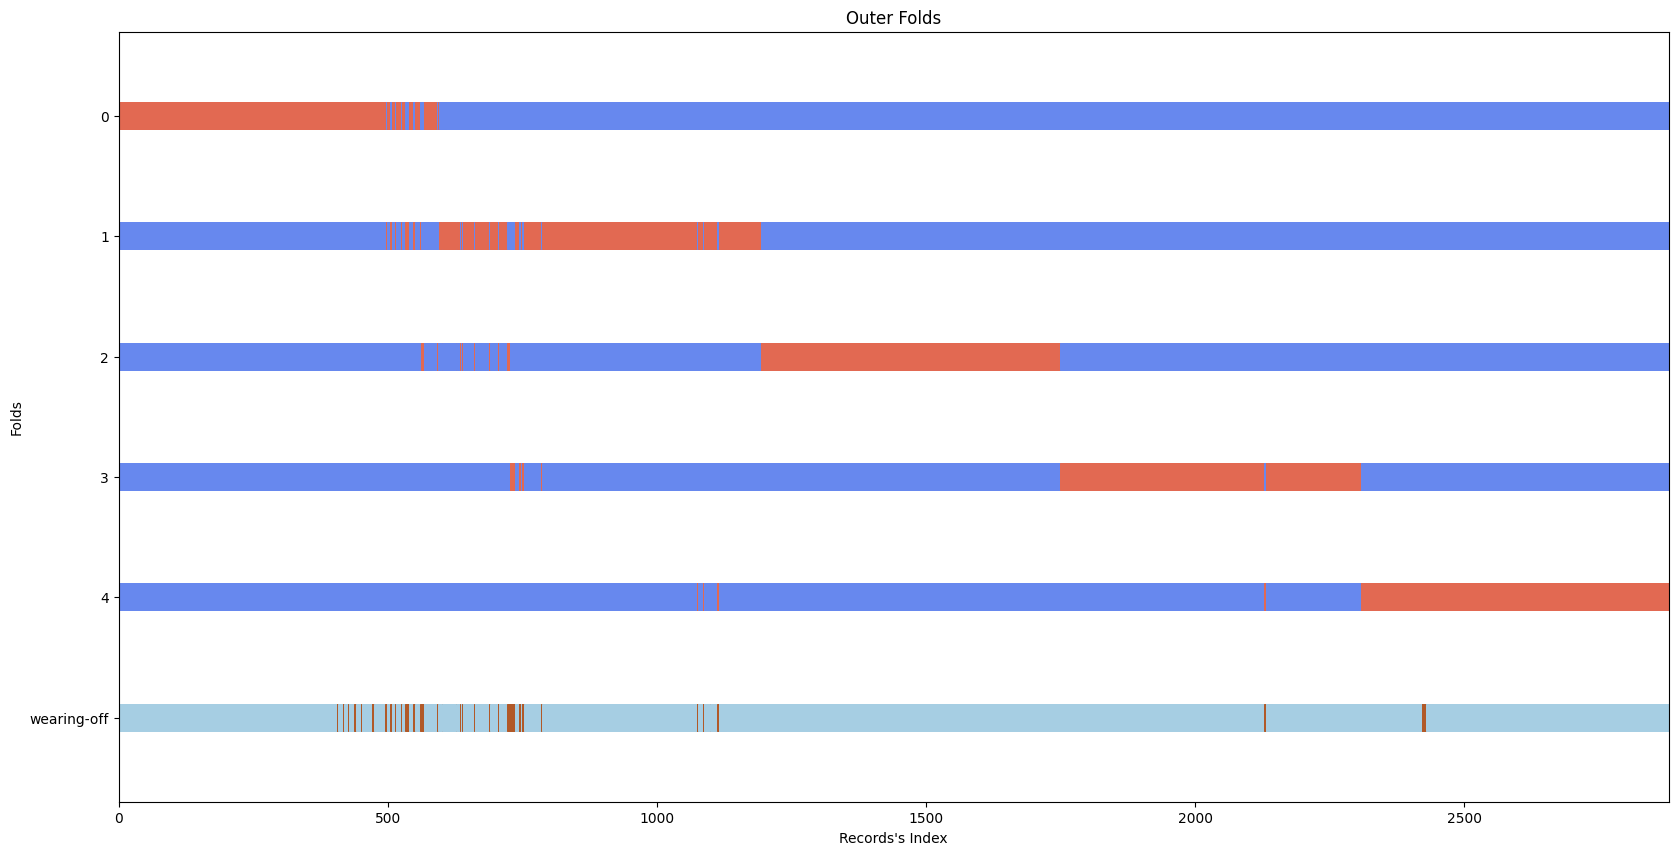

Train Set for Outer Fold 0
[ 505  512  513 ... 2877 2878 2879]

Train Set for Outer Fold 1
[   0    1    2 ... 2877 2878 2879]

Train Set for Outer Fold 2
[   0    1    2 ... 2877 2878 2879]

Train Set for Outer Fold 3
[   0    1    2 ... 2877 2878 2879]

Train Set for Outer Fold 4
[   0    1    2 ... 2313 2314 2315]



In [9]:
# Outer CV
fig, ax = plt.subplots(figsize=(20,10))
cv = StratifiedKFold(n_splits=5, shuffle=False)
plot_cv_indices(cv, X, y, ax)
plt.rc('text') # , usetex=False)
plt.rc('font', family='serif')
plt.title('Outer Folds')
# Save as file
# plt.savefig('./blockingtimeseriessplit.pdf', bbox_inches='tight')
plt.show()

training_folds = []
for train, test in cv.split(X, y):
    print(f'Train Set for Outer Fold {len(training_folds)}')
    print(train)
    training_folds.append(train)
    # print("Test")
    # print(test[0], test[-1])
    print()

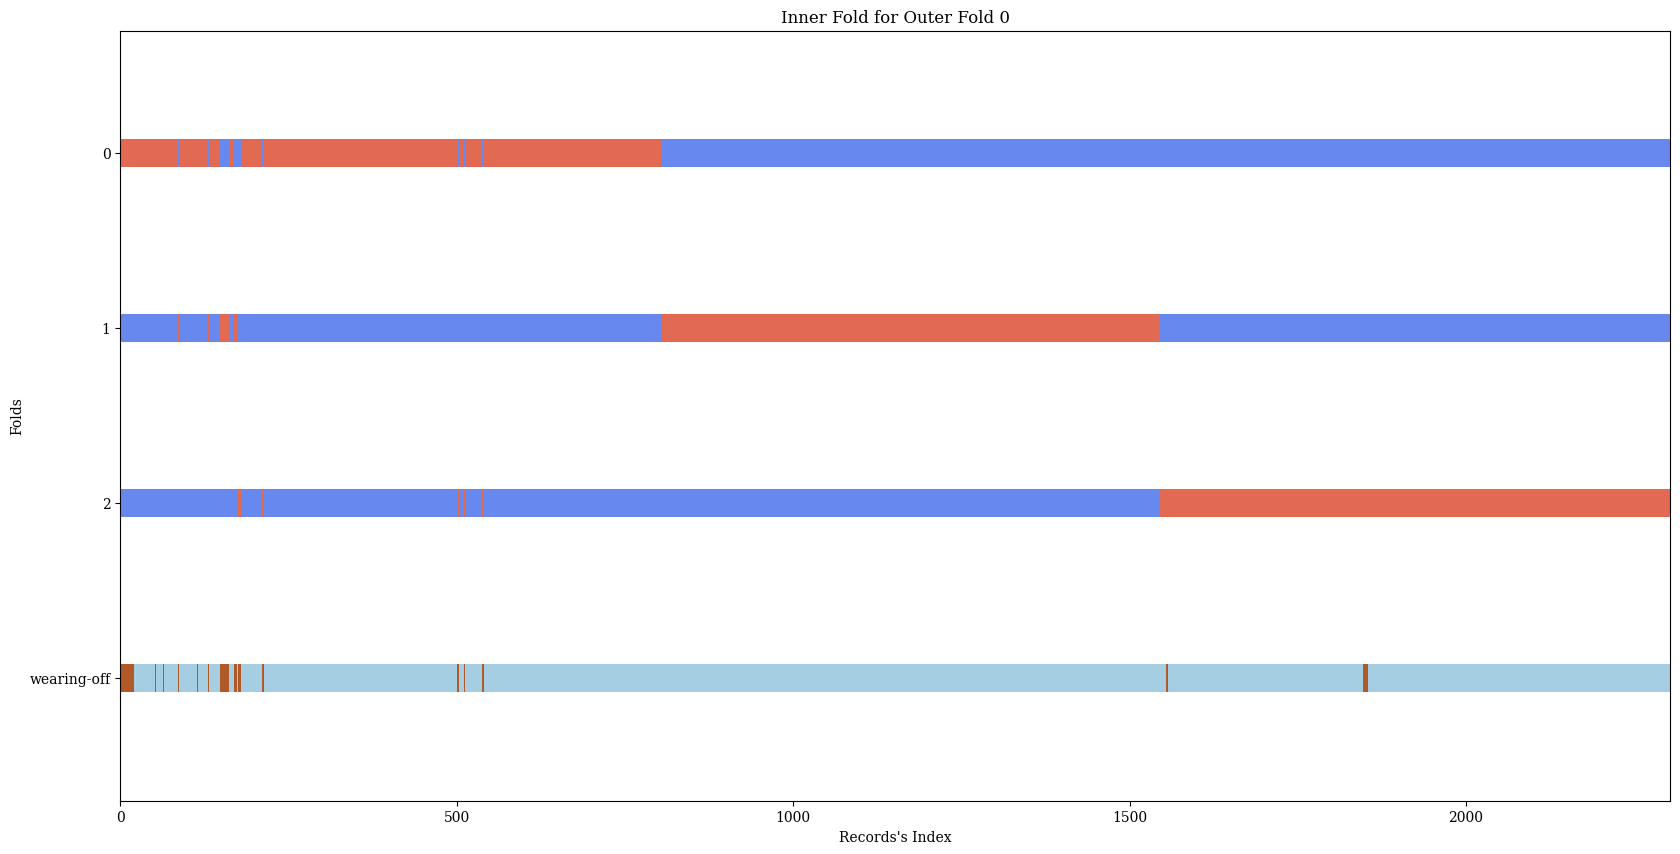

Train Sets for Outer Fold 0
Train Set for Inner Fold 0
[  32   58   66 ... 2301 2302 2303]

Train Set for Inner Fold 1
[   0    1    2 ... 2301 2302 2303]

Train Set for Inner Fold 2
[   0    1    2 ... 1548 1549 1550]



In [10]:
# Inner CV
outer_fold_number = 0

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
fig, ax = plt.subplots(figsize=(20,10))
cv = StratifiedKFold(n_splits=3, shuffle=False)
plot_cv_indices(cv, X.iloc[training_folds[outer_fold_number]], y[training_folds[outer_fold_number]], ax)
plt.rc('text') # , usetex=False)
plt.rc('font', family='serif')
plt.title(f'Inner Fold for Outer Fold {outer_fold_number}')
# Save as file
# plt.savefig('./blockingtimeseriessplit.pdf', bbox_inches='tight')
plt.show()

inner_training_folds = []
print(f'Train Sets for Outer Fold {outer_fold_number}')
for train, test in cv.split(X.iloc[training_folds[outer_fold_number]], y[training_folds[outer_fold_number]]):
    print(f'Train Set for Inner Fold {len(inner_training_folds)}')
    print(train)
    inner_training_folds.append(train)
    # print("Test")
    # print(test[0], test[-1])
    print()

# Pipeline

## Define learning algorithms

In [11]:
estimator_selection = Switch('estimators')
estimator_selection += PipelineElement("LogisticRegression",
                           hyperparameters={
                               'C': FloatRange(1, 10)
                           }, class_weight='balanced', random_state=4)
estimator_selection += PipelineElement("DecisionTreeClassifier",
                           hyperparameters={
                               'min_samples_split': IntegerRange(2,30),
                               'min_samples_leaf': IntegerRange(2,30)
                           }, random_state=4, criterion='gini')
estimator_selection += PipelineElement('LinearSVC',
                            hyperparameters={
                                'C': FloatRange(1, 25)
                            }, class_weight='balanced', random_state=4)
estimator_selection += PipelineElement('RandomForestClassifier', 
                            hyperparameters={
                                'min_samples_split': IntegerRange(2,30),
                                'max_features': ['auto', 'sqrt', 'log2']
                            }, random_state=4, criterion='gini', bootstrap=True)
estimator_selection += PipelineElement('GradientBoostingClassifier', 
                            hyperparameters={
                                'loss': ['deviance', 'exponential'],
                                'learning_rate': FloatRange(0.001, 1, 'logspace')
                            }, random_state=4)

## Initial Pipeline

In [12]:
initial_pipeline = Hyperpipe('1 - Initial Pipeline',
                     outer_cv = StratifiedKFold(n_splits=5, shuffle=False),
                     inner_cv = StratifiedKFold(n_splits=3, shuffle=False),
                     use_test_set = False,
                     metrics = list(metrics.keys()),
                     best_config_metric='balanced_accuracy',
                     optimizer='switch',
                     optimizer_params={'name': 'sk_opt', 'n_configurations': 30},
                     project_folder=f'./analysis/{dataset_type}{user}_{frequency}',
                     cache_folder=f'./cache/{dataset_type}{user}_{frequency}/',
                     verbosity=1,
                     performance_constraints=[MinimumPerformanceConstraint('balanced_accuracy', 0.75, 'mean')])

# Add learning algorithms to compare
initial_pipeline += estimator_selection

# Fit hyperpipe
initial_pipeline.fit(X, y)

# Show learning algorithms mean validation results
# print("Comparison on learning algorithms on validation set")
# print(initial_pipeline.results_handler.get_mean_of_best_validation_configs_per_estimator())

# # Show feature importances
# print_feature_importances(initial_pipeline)

# # View CV splits for debugging
# for k,v in initial_pipeline.cross_validation.outer_folds.items():
#     print(v.train_indices)
#     print(v.test_indices)
#     print(len(v.train_indices), len(v.test_indices))
#     print()

# Write other reports to summary file
add_other_report_to_summary(initial_pipeline)

12/06/2025-12:35:13 | Output Folder: ./analysis/participant2_15min\1InitialPipeline_results_2025-06-12_12-35-13
PHOTONAI ANALYSIS: 1InitialPipeline
12/06/2025-12:35:13 | Preparing data and PHOTONAI objects for analysis...
12/06/2025-12:35:13 | Checking input data...
12/06/2025-12:35:13 | Running analysis with 2880 samples.
Found 2 target classes: [0 1]
Target classes are imbalanced: 96.5625% belongs to 0
12/06/2025-12:35:13 | Removing cache files...

*****************************************************************************************************
Outer Cross validation Fold 1
*****************************************************************************************************
12/06/2025-12:35:13 | Preparing data for outer fold 1...
12/06/2025-12:35:13 | Preparing Hyperparameter Optimization...
12/06/2025-12:35:13 | Running Dummy Estimator...
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "LogisticR

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:35:38 | Skipped further cross validation after fold 3 due to performance constraints in balanced_accuracy
12/06/2025-12:35:38 | Computed configuration 96/150 in 0:00:00.516641
12/06/2025-12:35:38 | Performance:             balanced_accuracy - Train: 0.9311, Validation: 0.7110
12/06/2025-12:35:38 | Best Performance So Far: balanced_accuracy - Train: 0.8771, Validation: 0.8875
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:35:38 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:35:38 | Computed configuration 97/150 in 0:00:00.167739
12/06/2025-12:35:38 | Performance:             balanced_accuracy - Train: 0.9997, Validation: 0.7287
12/06/2025-12:35:38 | Best Pe

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=8",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:35:40 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:35:40 | Computed configuration 102/150 in 0:00:00.166726
12/06/2025-12:35:40 | Performance:             balanced_accuracy - Train: 0.9902, Validation: 0.7136
12/06/2025-12:35:40 | Best Performance So Far: balanced_accuracy - Train: 0.8771, Validation: 0.8875
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=5",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:35:41 | Skipped f

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=2",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:35:46 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:35:46 | Computed configuration 112/150 in 0:00:00.166669
12/06/2025-12:35:46 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.7287
12/06/2025-12:35:46 | Best Performance So Far: balanced_accuracy - Train: 0.8771, Validation: 0.8875
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=3",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:35:46 | Skipped f

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=28",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:35:47 | Skipped further cross validation after fold 3 due to performance constraints in balanced_accuracy
12/06/2025-12:35:47 | Computed configuration 115/150 in 0:00:00.516736
12/06/2025-12:35:47 | Performance:             balanced_accuracy - Train: 0.9310, Validation: 0.6984
12/06/2025-12:35:47 | Best Performance So Far: balanced_accuracy - Train: 0.8771, Validation: 0.8875
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=27",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:35:48 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=19",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:35:50 | Skipped further cross validation after fold 3 due to performance constraints in balanced_accuracy
12/06/2025-12:35:50 | Computed configuration 119/150 in 0:00:00.533368
12/06/2025-12:35:50 | Performance:             balanced_accuracy - Train: 0.9344, Validation: 0.6785
12/06/2025-12:35:50 | Best Performance So Far: balanced_accuracy - Train: 0.8771, Validation: 0.8875
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=8",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:35:51 | Skipped 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:35:53 | Computed configuration 125/150 in 0:00:00.716671
12/06/2025-12:35:53 | Performance:             balanced_accuracy - Train: 0.9813, Validation: 0.7781
12/06/2025-12:35:53 | Best Performance So Far: balanced_accuracy - Train: 0.8771, Validation: 0.8875
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.05212780929227985",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:35:53 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:35:53 | Computed configuration 129/150 in 0:00:00.232620
12/06/2025-12:35:53 | Performance:             balanced_accuracy - Train: 0.5000, Validation: 0.5000
12/06/2025-12:35:53 | Best Performance So Far: balanced_accuracy - Train: 0.8771, Validation: 0.8875
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.2711354491499446",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:35:54 | Computed configuration 130/150 in 0:00:00.733389
12/06/2025-12:35:54 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.7871
12/06/2025-12:35:54 | Best Performance So Far: balanced_accuracy - Train: 0.8771, Validation: 0.8875
----------------------

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:36:32 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:36:32 | Computed configuration 97/150 in 0:00:00.170465
12/06/2025-12:36:32 | Performance:             balanced_accuracy - Train: 0.9997, Validation: 0.6754
12/06/2025-12:36:32 | Best Performance So Far: balanced_accuracy - Train: 0.9899, Validation: 0.7243
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=8",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:36:32 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:36:32 | Computed configuration 98/150 in 0:00:00.181263
12/06/2025-12:36:32 | Performance:             balanced_accuracy - Train: 0.9902, Validation: 0.6734
12/06/2025-12:36:32 | Best Pe

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=22",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:36:33 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:36:33 | Computed configuration 102/150 in 0:00:00.176992
12/06/2025-12:36:33 | Performance:             balanced_accuracy - Train: 0.9899, Validation: 0.6693
12/06/2025-12:36:33 | Best Performance So Far: balanced_accuracy - Train: 0.9899, Validation: 0.7243
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=21",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:36:33 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=18",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=22",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:36:36 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:36:36 | Computed configuration 109/150 in 0:00:00.165567
12/06/2025-12:36:36 | Performance:             balanced_accuracy - Train: 0.9899, Validation: 0.6693
12/06/2025-12:36:36 | Best Performance So Far: balanced_accuracy - Train: 0.9899, Validation: 0.7243
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=17",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:36:36 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=22",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:36:37 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:36:37 | Computed configuration 112/150 in 0:00:00.178081
12/06/2025-12:36:37 | Performance:             balanced_accuracy - Train: 0.9899, Validation: 0.6693
12/06/2025-12:36:37 | Best Performance So Far: balanced_accuracy - Train: 0.9899, Validation: 0.7243
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=9",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:36:37 | Skipped 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=17",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:36:39 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:36:39 | Computed configuration 116/150 in 0:00:00.164565
12/06/2025-12:36:39 | Performance:             balanced_accuracy - Train: 0.9899, Validation: 0.6879
12/06/2025-12:36:39 | Best Performance So Far: balanced_accuracy - Train: 0.9902, Validation: 0.7250
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=18",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=13",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:36:39 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:36:39 | Computed configuration 118/150 in 0:00:00.163598
12/06/2025-12:36:39 | Performance:             balanced_accuracy - Train: 0.9899, Validation: 0.6872
12/06/2025-12:36:39 | Best Performance So Far: balanced_accuracy - Train: 0.9902, Validation: 0.7250
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=11",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:36:40 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:36:42 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:36:42 | Computed configuration 125/150 in 0:00:00.223416
12/06/2025-12:36:42 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.6694
12/06/2025-12:36:42 | Best Performance So Far: balanced_accuracy - Train: 0.9902, Validation: 0.7250
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.05212780929227985",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:36:42 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:36:42 | Computed configuration 129/150 in 0:00:00.221288
12/06/2025-12:36:42 | Performance:             balanced_accuracy - Train: 0.5000, Validation: 0.5000
12/06/2025-12:36:42 | Best Performance So Far: balanced_accuracy - Train: 0.9902, Validation: 0.7250
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.2711354491499446",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:36:42 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:36:42 | Computed configuration 130/150 in 0:00:00.221843
12/06/2025-12:36:42 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.6549
12/

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:37:11 | Computed configuration 96/150 in 0:00:00.171836
12/06/2025-12:37:11 | Performance:             balanced_accuracy - Train: 0.9892, Validation: 0.6792
12/06/2025-12:37:11 | Best Performance So Far: balanced_accuracy - Train: 0.9046, Validation: 0.7150
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:37:11 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:37:11 | Computed configuration 97/150 in 0:00:00.179318
12/06/2025-12:37:11 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.6465
12/06/2025-12:37:11 | Best Performance So Far: balanced_accuracy - Train: 0.9046, Validation: 0.7150
------------------------------------------------

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=21",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:37:12 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:37:12 | Computed configuration 102/150 in 0:00:00.177041
12/06/2025-12:37:12 | Performance:             balanced_accuracy - Train: 0.9896, Validation: 0.7338
12/06/2025-12:37:12 | Best Performance So Far: balanced_accuracy - Train: 0.9896, Validation: 0.7345
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=2",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:37:12 | Skipped 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:37:15 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:37:15 | Computed configuration 108/150 in 0:00:00.162530
12/06/2025-12:37:15 | Performance:             balanced_accuracy - Train: 0.9892, Validation: 0.7298
12/06/2025-12:37:15 | Best Performance So Far: balanced_accuracy - Train: 0.9896, Validation: 0.7345
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=21",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:37:15 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=2",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:37:16 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:37:16 | Computed configuration 112/150 in 0:00:00.177080
12/06/2025-12:37:16 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.6371
12/06/2025-12:37:16 | Best Performance So Far: balanced_accuracy - Train: 0.9896, Validation: 0.7345
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=3",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:37:17 | Skipped f

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=28",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:37:18 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:37:18 | Computed configuration 115/150 in 0:00:00.168723
12/06/2025-12:37:18 | Performance:             balanced_accuracy - Train: 0.9892, Validation: 0.7062
12/06/2025-12:37:18 | Best Performance So Far: balanced_accuracy - Train: 0.9896, Validation: 0.7345
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=27",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:37:18 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:37:21 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:37:21 | Computed configuration 125/150 in 0:00:00.234909
12/06/2025-12:37:21 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.6165
12/06/2025-12:37:21 | Best Performance So Far: balanced_accuracy - Train: 0.9896, Validation: 0.7345
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.05212780929227985",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:37:22 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:37:22 | Computed configuration 129/150 in 0:00:00.222166
12/06/2025-12:37:22 | Performance:             balanced_accuracy - Train: 0.5000, Validation: 0.5000
12/06/2025-12:37:22 | Best Performance So Far: balanced_accuracy - Train: 0.9896, Validation: 0.7345
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.2711354491499446",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:37:22 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:37:22 | Computed configuration 130/150 in 0:00:00.254098
12/06/2025-12:37:22 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.6034
12/

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:37:50 | Computed configuration 96/150 in 0:00:00.187455
12/06/2025-12:37:50 | Performance:             balanced_accuracy - Train: 0.9801, Validation: 0.6276
12/06/2025-12:37:50 | Best Performance So Far: balanced_accuracy - Train: 0.9973, Validation: 0.6894
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:37:51 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:37:51 | Computed configuration 97/150 in 0:00:00.167370
12/06/2025-12:37:51 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.6668
12/06/2025-12:37:51 | Best Performance So Far: balanced_accuracy - Train: 0.9973, Validation: 0.6894
------------------------------------------------

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=11",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:37:52 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:37:52 | Computed configuration 102/150 in 0:00:00.176951
12/06/2025-12:37:52 | Performance:             balanced_accuracy - Train: 0.9899, Validation: 0.6415
12/06/2025-12:37:52 | Best Performance So Far: balanced_accuracy - Train: 0.9973, Validation: 0.6894
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=5",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:37:52 | Skipped 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=18",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=22",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:37:55 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:37:55 | Computed configuration 109/150 in 0:00:00.177042
12/06/2025-12:37:55 | Performance:             balanced_accuracy - Train: 0.9896, Validation: 0.6455
12/06/2025-12:37:55 | Best Performance So Far: balanced_accuracy - Train: 0.9973, Validation: 0.6894
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=17",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:37:55 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=22",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:37:56 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:37:56 | Computed configuration 112/150 in 0:00:00.162488
12/06/2025-12:37:56 | Performance:             balanced_accuracy - Train: 0.9896, Validation: 0.6455
12/06/2025-12:37:56 | Best Performance So Far: balanced_accuracy - Train: 0.9973, Validation: 0.6894
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=9",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:37:56 | Skipped 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=25",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:37:59 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:37:59 | Computed configuration 118/150 in 0:00:00.180058
12/06/2025-12:37:59 | Performance:             balanced_accuracy - Train: 0.9801, Validation: 0.6276
12/06/2025-12:37:59 | Best Performance So Far: balanced_accuracy - Train: 0.9973, Validation: 0.6894
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=24",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:37:59 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:38:01 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:38:01 | Computed configuration 125/150 in 0:00:00.237177
12/06/2025-12:38:01 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.6363
12/06/2025-12:38:01 | Best Performance So Far: balanced_accuracy - Train: 0.9973, Validation: 0.6894
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.05212780929227985",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:38:01 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:38:01 | Computed configuration 129/150 in 0:00:00.212676
12/06/2025-12:38:01 | Performance:             balanced_accuracy - Train: 0.5000, Validation: 0.5000
12/06/2025-12:38:01 | Best Performance So Far: balanced_accuracy - Train: 0.9973, Validation: 0.6894
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.2711354491499446",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:38:01 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:38:01 | Computed configuration 130/150 in 0:00:00.237402
12/06/2025-12:38:01 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.6370
12/

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:38:30 | Computed configuration 96/150 in 0:00:00.175018
12/06/2025-12:38:30 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.3673
12/06/2025-12:38:30 | Best Performance So Far: balanced_accuracy - Train: 0.8868, Validation: 0.7392
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:38:30 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:38:30 | Computed configuration 97/150 in 0:00:00.172407
12/06/2025-12:38:30 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.4299
12/06/2025-12:38:30 | Best Performance So Far: balanced_accuracy - Train: 0.8868, Validation: 0.7392
------------------------------------------------

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:38:32 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:38:32 | Computed configuration 102/150 in 0:00:00.175969
12/06/2025-12:38:32 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.4555
12/06/2025-12:38:32 | Best Performance So Far: balanced_accuracy - Train: 0.8868, Validation: 0.7392
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=19",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:38:32 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=21",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=15",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:38:38 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:38:38 | Computed configuration 117/150 in 0:00:00.178012
12/06/2025-12:38:38 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.4535
12/06/2025-12:38:38 | Best Performance So Far: balanced_accuracy - Train: 0.8868, Validation: 0.7392
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=16",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:38:39 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.0032967498356970054",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:38:40 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:38:40 | Computed configuration 121/150 in 0:00:00.227066
12/06/2025-12:38:40 | Performance:             balanced_accuracy - Train: 0.5000, Validation: 0.5000
12/06/2025-12:38:40 | Best Performance So Far: balanced_accuracy - Train: 0.8868, Validation: 0.7392
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.06715939951134121",
        "estimator_name=GradientBoostin

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:38:41 | Skipped further cross validation after fold 2 due to performance constraints in balanced_accuracy
12/06/2025-12:38:41 | Computed configuration 125/150 in 0:00:00.425261
12/06/2025-12:38:41 | Performance:             balanced_accuracy - Train: 0.9432, Validation: 0.7213
12/06/2025-12:38:41 | Best Performance So Far: balanced_accuracy - Train: 0.8868, Validation: 0.7392
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.05212780929227985",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:38:41 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:38:41 | Computed configuration 129/150 in 0:00:00.216712
12/06/2025-12:38:41 | Performance:             balanced_accuracy - Train: 0.5000, Validation: 0.5000
12/06/2025-12:38:41 | Best Performance So Far: balanced_accuracy - Train: 0.8868, Validation: 0.7392
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.2711354491499446",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:38:42 | Skipped further cross validation after fold 2 due to performance constraints in balanced_accuracy
12/06/2025-12:38:42 | Computed configuration 130/150 in 0:00:00.393507
12/06/2025-12:38:42 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.6925
12/

## Feature Selection Pipeline

In [13]:
classifier = LogisticRegression(random_state=4).fit(X, y)

feature_selection_pipeline = Hyperpipe('2 - Feature Selection Pipline',
                     outer_cv = StratifiedKFold(n_splits=5, shuffle=False),
                     inner_cv = StratifiedKFold(n_splits=3, shuffle=False),
                     use_test_set = False,
                     metrics = list(metrics.keys()),
                     best_config_metric='balanced_accuracy',
                     optimizer='switch',
                     optimizer_params={'name': 'sk_opt', 'n_configurations': 30},
                     project_folder=f'./analysis/{dataset_type}{user}_{frequency}',
                     cache_folder=f'./cache/{dataset_type}{user}_{frequency}/',
                     verbosity=1,
                     performance_constraints=[MinimumPerformanceConstraint('balanced_accuracy', 0.75, 'mean')])

feature_selection_pipeline += PipelineElement('RFE', 
                           hyperparameters={
                               'n_features_to_select': IntegerRange(2, (len(columns) - 2))
                           }, estimator=classifier)

feature_selection_pipeline += estimator_selection

# Fit hyperpipe
feature_selection_pipeline.fit(X, y)

# Show learning algorithms mean validation results
# print("Comparison on learning algorithms on validation set")
# print(feature_selection_pipeline.results_handler.get_mean_of_best_validation_configs_per_estimator())

# # Show feature importances
# print_feature_importances(feature_selection_pipeline)

# # View CV splits for debugging
# for k,v in feature_selection_pipeline.cross_validation.outer_folds.items():
#     print(v.train_indices)
#     print(v.test_indices)
#     print(len(v.train_indices), len(v.test_indices))
#     print()

# Write other reports to summary file
add_other_report_to_summary(feature_selection_pipeline)

12/06/2025-12:38:58 | Output Folder: ./analysis/participant2_15min\2FeatureSelectionPipline_results_2025-06-12_12-38-58
PHOTONAI ANALYSIS: 2FeatureSelectionPipline
12/06/2025-12:38:58 | Preparing data and PHOTONAI objects for analysis...
12/06/2025-12:38:58 | Checking input data...
12/06/2025-12:38:58 | Running analysis with 2880 samples.
Found 2 target classes: [0 1]
Target classes are imbalanced: 96.5625% belongs to 0
JsonTransformer was unable to create the .json file.
12/06/2025-12:38:58 | Removing cache files...

*****************************************************************************************************
Outer Cross validation Fold 1
*****************************************************************************************************
12/06/2025-12:38:58 | Preparing data for outer fold 1...
12/06/2025-12:38:58 | Preparing Hyperparameter Optimization...
12/06/2025-12:38:58 | Running Dummy Estimator...
-------------------------------------------------------------------------

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:39:26 | Skipped further cross validation after fold 3 due to performance constraints in balanced_accuracy
12/06/2025-12:39:26 | Computed configuration 96/150 in 0:00:00.533442
12/06/2025-12:39:26 | Performance:             balanced_accuracy - Train: 0.9344, Validation: 0.6885
12/06/2025-12:39:26 | Best Performance So Far: balanced_accuracy - Train: 0.9888, Validation: 0.8320
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:39:26 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:39:26 | Computed configuration 97/150 in 0:00:00.166601
12/06/2025-12:39:26 | Performance:             balanced_accuracy - Train: 0.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:39:27 | Skipped further cross validation after fold 3 due to performance constraints in balanced_accuracy
12/06/2025-12:39:27 | Computed configuration 100/150 in 0:00:00.516625
12/06/2025-12:39:27 | Performance:             balanced_accuracy - Train: 0.9311, Validation: 0.7110
12/06/2025-12:39:27 | Best Performance So Far: balanced_accuracy - Train: 0.9888, Validation: 0.8320
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=27",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:39:27 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:39:27 | Computed configuration 101/150 in 0:00:00.149189
12/06/2025-12:39:27 | Performance:             balanced_accuracy - Train: 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=8"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=24",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=24",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:39:35 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:39:35 | Computed configuration 116/150 in 0:00:00.166690
12/06/2025-12:39:35 | Performance:             balanced_accuracy - Train: 0.9899, Validation: 0.7032
12/06/2025-12:39:35 | Best Performance So Far: balanced_accuracy - Train: 0.9888, Validation: 0.8320
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=29",
        "RandomForestClassifier_

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.3688610897684593",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, jo

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:39:38 | Computed configuration 122/150 in 0:00:00.183261
12/06/2025-12:39:38 | Performance:             balanced_accuracy - Train: 0.5000, Validation: 0.5000
12/06/2025-12:39:38 | Best Performance So Far: balanced_accuracy - Train: 0.9888, Validation: 0.8320
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.12452619203268588",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_sco

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:39:38 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:39:38 | Computed configuration 125/150 in 0:00:00.200059
12/06/2025-12:39:38 | Performance:             balanced_accuracy - Train: 0.5000, Validation: 0.5000
12/06/2025-12:39:38 | Best Performance So Far: balanced_accuracy - Train: 0.9888, Validation: 0.8320
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.06194436878055191",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.001140444703947033",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:39:38 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:39:38 | Computed configuration 128/150 in 0:00:00.200104
12/06/2025-12:39:38 | Performance:             balanced_accuracy - Train: 0.5000, Validation: 0.5000
12/06/2025-12:39:38 | Best Performance So Far: balanced_accuracy - Train: 0.9888, Validation: 0.8320
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=12"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.39707074960577515",
        "estimator_name=GradientBoo

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.13041400581263063",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:39:40 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:39:40 | Computed configuration 131/150 in 0:00:00.166803
12/06/2025-12:39:40 | Performance:             balanced_accuracy - Train: 0.8302, Validation: 0.4312
12/06/2025-12:39:40 | Best Performance So Far: balanced_accuracy - Train: 0.9888, Validation: 0.8320
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:40:20 | Computed configuration 96/150 in 0:00:00.170868
12/06/2025-12:40:20 | Performance:             balanced_accuracy - Train: 0.9899, Validation: 0.6693
12/06/2025-12:40:20 | Best Performance So Far: balanced_accuracy - Train: 0.9899, Validation: 0.7196
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:40:20 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:40:20 | Computed configuration 97/150 in 0:00:00.166993
12/06/2025-12:40:20 | Performance:             balanced_accuracy - Train: 0.9899, Validation: 0.6575
12/06/2025-12:40:20 | Best Performance So Far: balanced_accuracy - Train: 0.9899, Validation: 0

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:40:20 | Computed configuration 100/150 in 0:00:00.166343
12/06/2025-12:40:20 | Performance:             balanced_accuracy - Train: 0.9899, Validation: 0.7176
12/06/2025-12:40:20 | Best Performance So Far: balanced_accuracy - Train: 0.9899, Validation: 0.7196
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=27",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:40:21 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:40:21 | Computed configuration 101/150 in 0:00:00.166872
12/06/2025-12:40:21 | Performance:             balanced_accuracy - Train: 0.8012, Validation: 0.4966
12/06/2025-12:40:21 | Best Performance So Far: balanced_accuracy - Train: 0.9899, Validation:

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=14",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=12"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=29",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:40:26 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:40:26 | Computed configuration 113/150 in 0:00:00.166681
12/06/2025-12:40:26 | Performance:             balanced_accuracy - Train: 0.9899, Validation: 0.6818
12/06/2025-12:40:26 | Best Performance So Far: balanced_accuracy - Train: 0.9899, Validation: 0.7196
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=11"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=26",
        "RandomForestClassifie

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:40:30 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:40:30 | Computed configuration 122/150 in 0:00:00.200098
12/06/2025-12:40:30 | Performance:             balanced_accuracy - Train: 0.5000, Validation: 0.5000
12/06/2025-12:40:30 | Best Performance So Far: balanced_accuracy - Train: 0.9899, Validation: 0.7250
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.12452619203268588",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:40:30 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:40:30 | Computed configuration 125/150 in 0:00:00.199953
12/06/2025-12:40:30 | Performance:             balanced_accuracy - Train: 0.5000, Validation: 0.5000
12/06/2025-12:40:30 | Best Performance So Far: balanced_accuracy - Train: 0.9899, Validation: 0.7250
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.06194436878055191",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:40:30 | Computed configuration 127/150 in 0:00:00.199158
12/06/2025-12:40:30 | Performance:             balanced_accuracy - Train: 0.5000, Validation: 0.5000
12/06/2025-12:40:30 | Best Performance So Far: balanced_accuracy - Train: 0.9899, Validation: 0.7250
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.001140444703947033",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:40:30 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:40:30 | Computed configuration 128/150 in 0:00:00.183337
12/06/2025-12:40:30 | Performance:             balanced_accuracy - Train: 0.5000, Validation: 0.5000
12/06/2025-12:40:30 | Best Performance So Far: balanced_accuracy - T

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.13041400581263063",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:40:31 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:40:31 | Computed configuration 131/150 in 0:00:00.148729
12/06/2025-12:40:31 | Performance:             balanced_accuracy - Train: 0.8302, Validation: 0.4993
12/06/2025-12:40:31 | Best Performance So Far: balanced_accuracy - Train: 0.9899, Validation: 0.7250
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:41:04 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:41:04 | Computed configuration 96/150 in 0:00:00.200062
12/06/2025-12:41:04 | Performance:             balanced_accuracy - Train: 0.9896, Validation: 0.7345
12/06/2025-12:41:04 | Best Performance So Far: balanced_accuracy - Train: 0.9896, Validation: 0.7345
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:41:04 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:41:04 | Computed configuration 97/150 in 0:00:00.183258
12/06/2025-12:41:04 | Performance:             balanced_accuracy - Train: 0.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:41:04 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:41:04 | Computed configuration 100/150 in 0:00:00.183429
12/06/2025-12:41:04 | Performance:             balanced_accuracy - Train: 0.9892, Validation: 0.6792
12/06/2025-12:41:04 | Best Performance So Far: balanced_accuracy - Train: 0.9896, Validation: 0.7345
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=27",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:41:04 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:41:04 | Computed configuration 101/150 in 0:00:00.150101
12/06/2025-12:41:04 | Performance:             balanced_accuracy - Train: 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=3"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=14",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:41:13 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:41:13 | Computed configuration 119/150 in 0:00:00.233406
12/06/2025-12:41:13 | Performance:             balanced_accuracy - Train: 0.7925, Validation: 0.6391
12/06/2025-12:41:13 | Best Performance So Far: balanced_accuracy - Train: 0.9896, Validation: 0.7345
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=8",
        "RandomForestClassifier__

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.3688610897684593",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, jo

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:41:14 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:41:14 | Computed configuration 122/150 in 0:00:00.220680
12/06/2025-12:41:14 | Performance:             balanced_accuracy - Train: 0.5000, Validation: 0.5000
12/06/2025-12:41:14 | Best Performance So Far: balanced_accuracy - Train: 0.9896, Validation: 0.7345
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.12452619203268588",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

{
    "RFE": [
        "n_features_to_select=8"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.006301171989311478",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:41:14 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:41:14 | Computed configuration 127/150 in 0:00:00.146379
12/06/2025-12:41:14 | Performance:             balanced_accuracy - Train: 0.5000, Validation: 0.5000
12/06/2025-12:41:14 | Best Performance So Far: balanced_accuracy - Train: 0.9896, Validation: 0.7345
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.001140444703947033",
        "estimator_name=GradientBoo

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.13041400581263063",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:41:15 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:41:15 | Computed configuration 131/150 in 0:00:00.150051
12/06/2025-12:41:15 | Performance:             balanced_accuracy - Train: 0.9993, Validation: 0.6381
12/06/2025-12:41:15 | Best Performance So Far: balanced_accuracy - Train: 0.9896, Validation: 0.7345
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:41:45 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:41:45 | Computed configuration 97/150 in 0:00:00.163903
12/06/2025-12:41:45 | Performance:             balanced_accuracy - Train: 0.9892, Validation: 0.6752
12/06/2025-12:41:45 | Best Performance So Far: balanced_accuracy - Train: 0.9966, Validation: 0.6894
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=8"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=8",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' paramete

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:41:45 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:41:45 | Computed configuration 100/150 in 0:00:00.199513
12/06/2025-12:41:45 | Performance:             balanced_accuracy - Train: 0.9801, Validation: 0.6276
12/06/2025-12:41:45 | Best Performance So Far: balanced_accuracy - Train: 0.9966, Validation: 0.6894
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=10"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=29",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:41:45 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:41:45 | Computed configuration 101/150 in 0:00:00.157866
12/06/2025-12:41:45 | Performance:             balanced_accuracy - Train:

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=24",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:41:52 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:41:52 | Computed configuration 116/150 in 0:00:00.149888
12/06/2025-12:41:52 | Performance:             balanced_accuracy - Train: 0.7736, Validation: 0.6391
12/06/2025-12:41:52 | Best Performance So Far: balanced_accuracy - Train: 0.9966, Validation: 0.6894
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=4",
        "RandomForestClassifier__

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:41:54 | Performance:             balanced_accuracy - Train: 0.5000, Validation: 0.5000
12/06/2025-12:41:54 | Best Performance So Far: balanced_accuracy - Train: 0.9966, Validation: 0.6894
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.12452619203268588",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:41:55 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:41:55 | Computed configuration 127/150 in 0:00:00.149877
12/06/2025-12:41:55 | Performance:             balanced_accuracy - Train: 0.5000, Validation: 0.5000
12/06/2025-12:41:55 | Best Performance So Far: balanced_accuracy - Train: 0.9966, Validation: 0.6894
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.001140444703947033",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:41:55 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:41:55 | Computed configuration 128/150 in 0:00:00.165617
12/06/2025-12:41:55 | Performance:             ba

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.13041400581263063",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:41:56 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:41:56 | Computed configuration 131/150 in 0:00:00.132070
12/06/2025-12:41:56 | Performance:             balanced_accuracy - Train: 0.9993, Validation: 0.6600
12/06/2025-12:41:56 | Best Performance So Far: balanced_accuracy - Train: 0.9966, Validation: 0.6894
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:42:27 | Computed configuration 96/150 in 0:00:00.183314
12/06/2025-12:42:27 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.3875
12/06/2025-12:42:27 | Best Performance So Far: balanced_accuracy - Train: 1.0000, Validation: 0.7439
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:42:27 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:42:27 | Computed configuration 97/150 in 0:00:00.183423
12/06/2025-12:42:27 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.5987
12/06/2025-12:42:27 | Best Performance So Far: balanced_accuracy - Train: 1.0000, Validation: 0

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:42:27 | Computed configuration 100/150 in 0:00:00.183361
12/06/2025-12:42:27 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.3673
12/06/2025-12:42:27 | Best Performance So Far: balanced_accuracy - Train: 1.0000, Validation: 0.7439
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=27",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:42:28 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:42:28 | Computed configuration 101/150 in 0:00:00.163719
12/06/2025-12:42:28 | Performance:             balanced_accuracy - Train: 0.9997, Validation: 0.6034
12/06/2025-12:42:28 | Best Performance So Far: balanced_accuracy - Train: 1.0000, Validation:

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:42:37 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:42:37 | Computed configuration 122/150 in 0:00:00.216707
12/06/2025-12:42:37 | Performance:             balanced_accuracy - Train: 0.5000, Validation: 0.5000
12/06/2025-12:42:37 | Best Performance So Far: balanced_accuracy - Train: 1.0000, Validation: 0.7439
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.12452619203268588",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:42:38 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:42:38 | Computed configuration 125/150 in 0:00:00.183360
12/06/2025-12:42:38 | Performance:             balanced_accuracy - Train: 0.5000, Validation: 0.5000
12/06/2025-12:42:38 | Best Performance So Far: balanced_accuracy - Train: 1.0000, Validation: 0.7439
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.06194436878055191",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:42:38 | Computed configuration 127/150 in 0:00:00.182952
12/06/2025-12:42:38 | Performance:             balanced_accuracy - Train: 0.5000, Validation: 0.5000
12/06/2025-12:42:38 | Best Performance So Far: balanced_accuracy - Train: 1.0000, Validation: 0.7439
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.001140444703947033",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:42:38 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:42:38 | Computed configuration 128/150 in 0:00:00.183224
12/06/2025-12:42:38 | Performance:             balanced_accuracy - Train: 0.5000, Validation: 0.5000
12/06/2025-12:42:38 | Best Performance So Far: balanced_accuracy - T

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.13041400581263063",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:42:39 | Skipped further cross validation after fold 2 due to performance constraints in balanced_accuracy
12/06/2025-12:42:39 | Computed configuration 131/150 in 0:00:00.265076
12/06/2025-12:42:39 | Performance:             balanced_accuracy - Train: 0.7500, Validation: 0.6348
12/06/2025-12:42:39 | Best Performance So Far: balanced_accuracy - Train: 1.0000, Validation: 0.7439
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        

## Class Imbalanced Pipeline

In [14]:
class_imbalanced_pipeline = Hyperpipe('3 - Class Imbalanced Pipline',
                     outer_cv = StratifiedKFold(n_splits=5, shuffle=False),
                     inner_cv = StratifiedKFold(n_splits=3, shuffle=False),
                     use_test_set = False,
                     metrics = list(metrics.keys()),
                     best_config_metric='balanced_accuracy',
                     optimizer='switch',
                     optimizer_params={'name': 'sk_opt', 'n_configurations': 30},
                     project_folder=f'./analysis/{dataset_type}{user}_{frequency}',
                     cache_folder=f'./cache/{dataset_type}{user}_{frequency}/',
                     verbosity=1,
                     performance_constraints=[MinimumPerformanceConstraint('balanced_accuracy', 0.75, 'mean')])

tested_methods = Categorical(['RandomUnderSampler', 'RandomOverSampler', 'SMOTE', 'BorderlineSMOTE'])
class_imbalanced_pipeline += PipelineElement('ImbalancedDataTransformer',
                           hyperparameters={ 'method_name': tested_methods })

class_imbalanced_pipeline += estimator_selection

# Fit hyperpipe
class_imbalanced_pipeline.fit(X, y)

# Show learning algorithms mean validation results
# print("Comparison on learning algorithms on validation set")
# print(class_imbalanced_pipeline.results_handler.get_mean_of_best_validation_configs_per_estimator())

# # Show feature importances
# print_feature_importances(class_imbalanced_pipeline)

# # View CV splits for debugging
# for k,v in class_imbalanced_pipeline.cross_validation.outer_folds.items():
#     print(v.train_indices)
#     print(v.test_indices)
#     print(len(v.train_indices), len(v.test_indices))
#     print()

# Write other reports to summary file
add_other_report_to_summary(class_imbalanced_pipeline)

12/06/2025-12:42:54 | Output Folder: ./analysis/participant2_15min\3ClassImbalancedPipline_results_2025-06-12_12-42-54
PHOTONAI ANALYSIS: 3ClassImbalancedPipline
12/06/2025-12:42:54 | Preparing data and PHOTONAI objects for analysis...
12/06/2025-12:42:54 | Checking input data...
12/06/2025-12:42:54 | Running analysis with 2880 samples.
Found 2 target classes: [0 1]
Target classes are imbalanced: 96.5625% belongs to 0
12/06/2025-12:42:54 | Removing cache files...

*****************************************************************************************************
Outer Cross validation Fold 1
*****************************************************************************************************
12/06/2025-12:42:54 | Preparing data for outer fold 1...
12/06/2025-12:42:54 | Preparing Hyperparameter Optimization...
12/06/2025-12:42:54 | Running Dummy Estimator...
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTrans

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:43:22 | Computed configuration 94/150 in 0:00:00.189684
12/06/2025-12:43:22 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.4480
12/06/2025-12:43:22 | Best Performance So Far: balanced_accuracy - Train: 0.9907, Validation: 0.9344
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:43:22 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:43:22 | Computed configuration 95/150 in 0:00:00.126434
12/06/2025-12:43:22 | Performance:             balanced_accuracy - Train: 0.9906, Validation: 0.3798
12/06/2025-12:43:22 | Best Performance So Far: balanced_accuracy 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:43:23 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:43:23 | Computed configuration 101/150 in 0:00:00.115820
12/06/2025-12:43:23 | Performance:             balanced_accuracy - Train: 0.9906, Validation: 0.3825
12/06/2025-12:43:23 | Best Performance So Far: balanced_accuracy - Train: 0.9907, Validation: 0.9344
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "estimators": [
        "RandomForestClassifie

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=30",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:43:36 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:43:36 | Computed configuration 115/150 in 0:00:00.200023
12/06/2025-12:43:36 | Performance:             balanced_accuracy - Train: 0.9990, Validation: 0.4480
12/06/2025-12:43:36 | Best Performance So Far: balanced_accuracy - Train: 0.9907, Validation: 0.9344
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_sampl

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:43:41 | Computed configuration 122/150 in 0:00:01.216792
12/06/2025-12:43:41 | Performance:             balanced_accuracy - Train: 0.9907, Validation: 0.8770
12/06/2025-12:43:41 | Best Performance So Far: balanced_accuracy - Train: 0.9907, Validation: 0.9344
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.5123132299514567",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:43:42 | Computed configuration 123/150 in 0:00:00.215605
12/06/2025-12:43:42 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.8662
12/06/2025-12:43:42 | Best Performance So Far: balanced_accuracy - Train: 0.9907, Validation: 0.9344
-----------------------------------------------------------

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:43:42 | Computed configuration 125/150 in 0:00:00.751054
12/06/2025-12:43:42 | Performance:             balanced_accuracy - Train: 0.9894, Validation: 0.9017
12/06/2025-12:43:42 | Best Performance So Far: balanced_accuracy - Train: 0.9907, Validation: 0.9344
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.006301171989311478",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:43:44 | Computed configuration 126/150 in 0:00:01.732423
12/06/2025-12:43:44 | Performance:             balanced_accuracy - Train: 0.9915, Validation: 0.8583
12/06/2025-12:43:44 | Best Performance So Far: balanced_accuracy - Train: 0.9907, Validation: 0.9344
------------------------------------------------------------

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:43:47 | Computed configuration 130/150 in 0:00:01.483323
12/06/2025-12:43:47 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.8273
12/06/2025-12:43:47 | Best Performance So Far: balanced_accuracy - Train: 0.9907, Validation: 0.9344
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.015966509444436554",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:43:48 | Computed configuration 131/150 in 0:00:00.766739
12/06/2025-12:43:48 | Performance:             balanced_accuracy - Train: 0.9898, Validation: 0.9017
12/06/2025-12:43:48 | Best Performance So Far: balanced_accuracy - Train: 0.9907, Validation: 0.9344
----------------------------------------------------------

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:44:36 | Computed configuration 94/150 in 0:00:00.198601
12/06/2025-12:44:36 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.6092
12/06/2025-12:44:36 | Best Performance So Far: balanced_accuracy - Train: 0.9990, Validation: 0.6863
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:44:37 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:44:37 | Computed configuration 95/150 in 0:00:00.132466
12/06/2025-12:44:37 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.7055
12/06/2025-12:44:37 | Best Performance So Far: balanced_accuracy 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=18",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:44:38 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:44:38 | Computed configuration 101/150 in 0:00:00.256675
12/06/2025-12:44:38 | Performance:             balanced_accuracy - Train: 0.9993, Validation: 0.6482
12/06/2025-12:44:38 | Best Performance So Far: balanced_accuracy - Train: 1.0000, Validation: 0.7055
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:44:47 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:44:47 | Computed configuration 122/150 in 0:00:00.433176
12/06/2025-12:44:47 | Performance:             balanced_accuracy - Train: 0.9987, Validation: 0.6759
12/06/2025-12:44:47 | Best Performance So Far: balanced_accuracy - Train: 1.0000, Validation: 0.7062
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.5123132299514567",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:44:47 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:44:47 | Computed configuration 123/150 in 0:00:00.066722
12/06/2025-12:44:47 |

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:44:48 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:44:48 | Computed configuration 125/150 in 0:00:00.265718
12/06/2025-12:44:48 | Performance:             balanced_accuracy - Train: 0.9980, Validation: 0.6698
12/06/2025-12:44:48 | Best Performance So Far: balanced_accuracy - Train: 1.0000, Validation: 0.7062
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.006301171989311478",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:44:48 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:44:48 | Computed configuration 126/150 in 0:00:00.653315
12/06/2025-12:44:48 | 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:44:49 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:44:49 | Computed configuration 130/150 in 0:00:00.426058
12/06/2025-12:44:49 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.6792
12/06/2025-12:44:49 | Best Performance So Far: balanced_accuracy - Train: 1.0000, Validation: 0.7062
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.002049128507720536",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:44:50 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:44:50 | Computed configuration 131/150 in 0:00:00.272090
12/06/2025-12:44:50 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:45:31 | Skipped further cross validation after fold 2 due to performance constraints in balanced_accuracy
12/06/2025-12:45:31 | Computed configuration 94/150 in 0:00:00.421616
12/06/2025-12:45:31 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.7061
12/06/2025-12:45:31 | Best Performance So Far: balanced_accuracy - Train: 0.9997, Validation: 0.7082
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:45:31 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:45:31 | Computed configuration 95/150 in 0:00:00.123876
12/06/2025-12:45:31 | Performance:            

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=18",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:45:32 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:45:32 | Computed configuration 101/150 in 0:00:00.294674
12/06/2025-12:45:32 | Performance:             balanced_accuracy - Train: 0.9990, Validation: 0.6429
12/06/2025-12:45:32 | Best Performance So Far: balanced_accuracy - Train: 1.0000, Validation: 0.7143
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:45:46 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:45:46 | Computed configuration 122/150 in 0:00:00.463256
12/06/2025-12:45:46 | Performance:             balanced_accuracy - Train: 0.9858, Validation: 0.5967
12/06/2025-12:45:46 | Best Performance So Far: balanced_accuracy - Train: 0.9973, Validation: 0.7412
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.5123132299514567",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:45:46 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:45:46 | Computed configuration 123/150 in 0:00:00.086432
12/06/2025-12:45:46 |

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:45:46 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:45:46 | Computed configuration 125/150 in 0:00:00.253809
12/06/2025-12:45:46 | Performance:             balanced_accuracy - Train: 0.9922, Validation: 0.6105
12/06/2025-12:45:46 | Best Performance So Far: balanced_accuracy - Train: 0.9973, Validation: 0.7412
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.006301171989311478",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:45:47 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:45:47 | Computed configuration 126/150 in 0:00:00.553852
12/06/2025-12:45:47 | 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:45:48 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:45:48 | Computed configuration 130/150 in 0:00:00.563277
12/06/2025-12:45:48 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.6199
12/06/2025-12:45:48 | Best Performance So Far: balanced_accuracy - Train: 0.9973, Validation: 0.7412
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.002049128507720536",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:45:49 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:45:49 | Computed configuration 131/150 in 0:00:00.261840
12/06/2025-12:45:49 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:46:28 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:46:28 | Computed configuration 94/150 in 0:00:00.185000
12/06/2025-12:46:28 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.6465
12/06/2025-12:46:28 | Best Performance So Far: balanced_accuracy - Train: 0.9980, Validation: 0.6974
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:46:28 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:46:28 | Computed configuration 95/150 in 0:00:00.135141
12/06/2025-12:46:28 | Performance:            

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=18",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:46:29 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:46:29 | Computed configuration 101/150 in 0:00:00.235310
12/06/2025-12:46:29 | Performance:             balanced_accuracy - Train: 0.9993, Validation: 0.6256
12/06/2025-12:46:29 | Best Performance So Far: balanced_accuracy - Train: 0.9980, Validation: 0.6974
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:46:39 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:46:39 | Computed configuration 120/150 in 0:00:00.199036
12/06/2025-12:46:39 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.6384
12/06/2025-12:46:39 | Best Performance So Far: balanced_accuracy - Train: 0.9980, Validation: 0.6974
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "GradientBoostingClassif

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:46:40 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:46:40 | Computed configuration 122/150 in 0:00:00.369528
12/06/2025-12:46:40 | Performance:             balanced_accuracy - Train: 0.9949, Validation: 0.6327
12/06/2025-12:46:40 | Best Performance So Far: balanced_accuracy - Train: 0.9980, Validation: 0.6974
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.5123132299514567",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:46:40 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:46:40 | Computed configuration 123/150 in 0:00:00.076444
12/06/2025-12:46:40 |

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:46:41 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:46:41 | Computed configuration 125/150 in 0:00:00.249913
12/06/2025-12:46:41 | Performance:             balanced_accuracy - Train: 0.9943, Validation: 0.6074
12/06/2025-12:46:41 | Best Performance So Far: balanced_accuracy - Train: 0.9980, Validation: 0.6974
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.006301171989311478",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:46:41 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:46:41 | Computed configuration 126/150 in 0:00:00.433515
12/06/2025-12:46:41 | 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:46:42 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:46:42 | Computed configuration 130/150 in 0:00:00.361289
12/06/2025-12:46:42 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.5911
12/06/2025-12:46:42 | Best Performance So Far: balanced_accuracy - Train: 0.9980, Validation: 0.6974
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.002049128507720536",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:46:42 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:46:42 | Computed configuration 131/150 in 0:00:00.255887
12/06/2025-12:46:42 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:47:21 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:47:21 | Computed configuration 95/150 in 0:00:00.141297
12/06/2025-12:47:21 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.4675
12/06/2025-12:47:21 | Best Performance So Far: balanced_accuracy - Train: 0.9924, Validation: 0.7365
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:47:21 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:47:21 | Computed configuration 96/150 in 0:00:00.203906
12/06/2025-12:47:21 | Performance:             balanced_acc

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:47:21 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:47:21 | Computed configuration 101/150 in 0:00:00.133393
12/06/2025-12:47:21 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.4098
12/06/2025-12:47:21 | Best Performance So Far: balanced_accuracy - Train: 0.9924, Validation: 0.7365
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "estimators": [
        "RandomForestClassifie

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:47:30 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:47:30 | Computed configuration 117/150 in 0:00:00.182039
12/06/2025-12:47:30 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.5488
12/06/2025-12:47:30 | Best Performance So Far: balanced_accuracy - Train: 0.9924, Validation: 0.7365
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "RandomForestClassifier_

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:47:33 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:47:33 | Computed configuration 122/150 in 0:00:00.394694
12/06/2025-12:47:33 | Performance:             balanced_accuracy - Train: 0.9919, Validation: 0.6402
12/06/2025-12:47:33 | Best Performance So Far: balanced_accuracy - Train: 0.9924, Validation: 0.7365
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.5123132299514567",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:47:33 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:47:33 | Computed configuration 123/150 in 0:00:00.072462
12/06/2025-12:47:33 |

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:47:33 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:47:33 | Computed configuration 125/150 in 0:00:00.239382
12/06/2025-12:47:33 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.7197
12/06/2025-12:47:33 | Best Performance So Far: balanced_accuracy - Train: 0.9924, Validation: 0.7365
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.006301171989311478",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:47:33 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:47:33 | Computed configuration 126/150 in 0:00:00.477514
12/06/2025-12:47:33 | 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.015966509444436554",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:47:35 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:47:35 | Computed configuration 131/150 in 0:00:00.250059
12/06/2025-12:47:35 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.7197
12/06/2025-12:47:35 | Best Performance So Far: balanced_accuracy - Train: 0.9924, Validation: 0.7365
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
       

In [15]:
import time
import os
from photonai.base.hyperpipe import OutputSettings

# Save original method
original_update_settings = OutputSettings.update_settings

def patched_update_settings(self, name, timestamp):
    max_retries = 5
    delay = 1  # seconds
    
    for attempt in range(max_retries):
        try:
            original_update_settings(self, name, timestamp)
            break  # success, exit retry loop
        except PermissionError as e:
            print(f"PermissionError on attempt {attempt+1}/{max_retries} when updating settings: {e}")
            if attempt < max_retries - 1:
                time.sleep(delay)
            else:
                print("Max retries reached. Raising the PermissionError.")
                raise

# Apply monkey patch
OutputSettings.update_settings = patched_update_settings


## Class Imbalanced + Feature Selection Pipeline

In [16]:
classifier = LogisticRegression(random_state=4).fit(X, y)

class_imbalanced_feature_selection_pipeline = Hyperpipe('4 - CI and FS Pipeline',
                     outer_cv = StratifiedKFold(n_splits=5, shuffle=False),
                     inner_cv = StratifiedKFold(n_splits=3, shuffle=False),
                     use_test_set = False,
                     metrics = list(metrics.keys()),
                     best_config_metric='balanced_accuracy',
                     optimizer='switch',
                     optimizer_params={'name': 'sk_opt', 'n_configurations': 30},
                     project_folder=f'./analysis/{dataset_type}{user}_{frequency}',
                     cache_folder=f'./cache/{dataset_type}{user}_{frequency}/',
                     verbosity=1,
                     performance_constraints=[MinimumPerformanceConstraint('balanced_accuracy', 0.75, 'mean')])


tested_methods = Categorical(['RandomUnderSampler', 'RandomOverSampler', 'SMOTE', 'BorderlineSMOTE'])
class_imbalanced_feature_selection_pipeline += PipelineElement('ImbalancedDataTransformer',
                           hyperparameters={ 'method_name': tested_methods })

class_imbalanced_feature_selection_pipeline += PipelineElement('RFE', 
                           hyperparameters={
                               'n_features_to_select': IntegerRange(2, (len(columns) - 2))
                           }, estimator=classifier)

class_imbalanced_feature_selection_pipeline += estimator_selection

# Fit hyperpipe
class_imbalanced_feature_selection_pipeline.fit(X, y)

# Show learning algorithms mean validation results

# print("Comparison on learning algorithms on validation set")
# print(class_imbalanced_feature_selection_pipeline.results_handler.get_mean_of_best_validation_configs_per_estimator())

# # Show feature importances
# print_feature_importances(class_imbalanced_feature_selection_pipeline)

# # View CV splits for debugging
# for k,v in class_imbalanced_feature_selection_pipeline.cross_validation.outer_folds.items():
#     print(v.train_indices)
#     print(v.test_indices)
#     print(len(v.train_indices), len(v.test_indices))
#     print()

# Write other reports to summary file
add_other_report_to_summary(class_imbalanced_feature_selection_pipeline)

12/06/2025-12:47:49 | Output Folder: ./analysis/participant2_15min\4CIandFSPipeline_results_2025-06-12_12-47-49
PHOTONAI ANALYSIS: 4CIandFSPipeline
12/06/2025-12:47:49 | Preparing data and PHOTONAI objects for analysis...
12/06/2025-12:47:49 | Checking input data...
12/06/2025-12:47:49 | Running analysis with 2880 samples.
Found 2 target classes: [0 1]
Target classes are imbalanced: 96.5625% belongs to 0
JsonTransformer was unable to create the .json file.
12/06/2025-12:47:49 | Removing cache files...

*****************************************************************************************************
Outer Cross validation Fold 1
*****************************************************************************************************
12/06/2025-12:47:49 | Preparing data for outer fold 1...
12/06/2025-12:47:49 | Preparing Hyperparameter Optimization...
12/06/2025-12:47:49 | Running Dummy Estimator...
-----------------------------------------------------------------------------------------

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:48:25 | Computed configuration 93/150 in 0:00:00.383387
12/06/2025-12:48:25 | Performance:             balanced_accuracy - Train: 0.9719, Validation: 0.8995
12/06/2025-12:48:25 | Best Performance So Far: balanced_accuracy - Train: 0.9750, Validation: 0.9146
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=8"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:48:27 | Skipped further cross validation after fold 3 due to performance constraints in balanced_accuracy
12/06/2025-12:48:27 | Computed configuration 94/150 in 0:00:01.298222
12/06/2025-12:48:27 | Performance:             balanced_accuracy - Train: 0.9737, Validation: 0.6966
12/06/2025-12:48:27 | Bes

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:48:30 | Skipped further cross validation after fold 3 due to performance constraints in balanced_accuracy
12/06/2025-12:48:30 | Computed configuration 98/150 in 0:00:01.483542
12/06/2025-12:48:30 | Performance:             balanced_accuracy - Train: 0.9185, Validation: 0.7337
12/06/2025-12:48:30 | Best Performance So Far: balanced_accuracy - Train: 0.9750, Validation: 0.9146
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:48:30 | Computed configuration 99/150 in 0:00:00.399970
12/06/2025-12:48:30 | Performance:             balanced_accuracy - Train: 0.9750, Validation: 0.9022
12/06/2025-1

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=14",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:48:34 | Computed configuration 104/150 in 0:00:00.383325
12/06/2025-12:48:34 | Performance:             balanced_accuracy - Train: 0.9782, Validation: 0.8936
12/06/2025-12:48:34 | Best Performance So Far: balanced_accuracy - Train: 0.9750, Validation: 0.9146
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_sampl

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:48:46 | Computed configuration 126/150 in 0:00:00.263839
12/06/2025-12:48:46 | Performance:             balanced_accuracy - Train: 0.9969, Validation: 0.9141
12/06/2025-12:48:46 | Best Performance So Far: balanced_accuracy - Train: 0.9750, Validation: 0.9146
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.003307472671791054",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:48:46 | Skipped further cross validation after fold 3 due to performance constraints in balanced_accuracy
12/06/2025-12:48:46 | Computed configuration 127/150 in 0:00:00.233535
12/06/2025-12:48:46 | Performance:             balanced_accuracy - Train: 0.9566, Vali

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=10"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.047855755146111796",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:48:48 | Skipped further cross validation after fold 3 due to performance constraints in balanced_accuracy
12/06/2025-12:48:48 | Computed configuration 131/150 in 0:00:01.066851
12/06/2025-12:48:48 | Performance:             balanced_accuracy - Train: 0.9726, Validation: 0.7262
12/06/2025-12:48:48 | Best Performance So Far: balanced_accuracy - Train: 0.9750, Validation: 0.9146
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_na

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:49:27 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:49:27 | Computed configuration 94/150 in 0:00:00.216619
12/06/2025-12:49:27 | Performance:             balanced_accuracy - Train: 0.9997, Validation: 0.5745
12/06/2025-12:49:27 | Best Performance So Far: balanced_accuracy - Train: 0.9987, Validation: 0.7123
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:49:28 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:49:28 | Computed configuration 95/150 in 0:00:00.200011
12/06/

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:49:29 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:49:29 | Computed configuration 98/150 in 0:00:00.550017
12/06/2025-12:49:29 | Performance:             balanced_accuracy - Train: 0.9990, Validation: 0.6657
12/06/2025-12:49:29 | Best Performance So Far: balanced_accuracy - Train: 0.9987, Validation: 0.7123
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:49:29 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:49:29 | Computed configuration 99/150 in 0:00:00.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=3"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=8",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:49:31 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:49:31 | Computed configuration 103/150 in 0:00:00.550125
12/06/2025-12:49:31 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.6178
12/06/2025-12:49:31 | Best Performance So Far: balanced_accuracy - Train: 0.9987, Validation: 0.7123
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],


Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 355, in fit_and_score
    curr_test_fold = InnerFoldManager.score(pipe, job.test_data.X, job.test_data.y, job.metrics,
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 431, in score
    y_pred = estimator.predict(X, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\ba

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=27",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:49:34 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:49:34 | Computed configuration 108/150 in 0:00:00.216710
12/06/2025-12:49:34 | Performance:             balanced_accuracy - Train: 0.9990, Validation: 0.6671
12/06/2025-12:49:34 | Best Performance So Far: balanced_accuracy - Train: 0.9987, Validation: 0.7123
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.1394594605714494",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:49:41 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:49:41 | Computed configuration 121/150 in 0:00:00.416746
12/06/2025-12:49:41 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.6823
12/06/2025-12:49:41 | Best Performance So Far: balanced_accuracy - Train: 0.9987, Validation: 0.7123
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SM

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:49:42 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:49:42 | Computed configuration 126/150 in 0:00:00.083463
12/06/2025-12:49:42 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.6402
12/06/2025-12:49:42 | Best Performance So Far: balanced_accuracy - Train: 0.9987, Validation: 0.7123
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.003307472671791054",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:49:42 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:49:42 | Computed config

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=10"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.047855755146111796",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:49:43 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:49:43 | Computed configuration 131/150 in 0:00:00.359043
12/06/2025-12:49:43 | Performance:             balanced_accuracy - Train: 0.9983, Validation: 0.6769
12/06/2025-12:49:43 | Best Performance So Far: balanced_accuracy - Train: 0.9987, Validation: 0.7123
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_na

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:50:24 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:50:24 | Computed configuration 94/150 in 0:00:00.383339
12/06/2025-12:50:24 | Performance:             balanced_accuracy - Train: 0.9993, Validation: 0.6179
12/06/2025-12:50:24 | Best Performance So Far: balanced_accuracy - Train: 0.5553, Validation: 0.7365
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:50:24 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:50:24 | Computed configuration 95/150 in 0:00:00.433380
12/06/

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:50:25 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:50:25 | Computed configuration 98/150 in 0:00:00.200786
12/06/2025-12:50:25 | Performance:             balanced_accuracy - Train: 0.9983, Validation: 0.6489
12/06/2025-12:50:25 | Best Performance So Far: balanced_accuracy - Train: 0.5553, Validation: 0.7365
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:50:25 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:50:25 | Computed configuration 99/150 in 0:00:00.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=30",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:50:27 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:50:27 | Computed configuration 103/150 in 0:00:00.370660
12/06/2025-12:50:27 | Performance:             balanced_accuracy - Train: 0.9983, Validation: 0.6321
12/06/2025-12:50:27 | Best Performance So Far: balanced_accuracy - Train: 0.5553, Validation: 0.7365
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE"

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 355, in fit_and_score
    curr_test_fold = InnerFoldManager.score(pipe, job.test_data.X, job.test_data.y, job.metrics,
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 431, in score
    y_pred = estimator.predict(X, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\ba

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=11"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=11",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:50:29 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:50:29 | Computed configuration 108/150 in 0:00:00.197258
12/06/2025-12:50:29 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.6402
12/06/2025-12:50:29 | Best Performance So Far: balanced_accuracy - Train: 0.5553, Validation: 0.7365
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "RFE": [
        "n_features_to_select=8"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=8",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:50:35 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:50:35 | Computed configuration 119/150 in 0:00:00.216686
12/06/2025-12:50:35 | Performance:             balanced_accuracy - Train: 0.9983, Validation: 0.6132
12/06/2025-12:50:35 | Best Performance So Far: balanced_accuracy - Train: 0.5553, Validation: 0.7365
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],


Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:50:37 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:50:37 | Computed configuration 127/150 in 0:00:00.082995
12/06/2025-12:50:37 | Performance:             balanced_accuracy - Train: 0.8962, Validation: 0.4801
12/06/2025-12:50:37 | Best Performance So Far: balanced_accuracy - Train: 0.5553, Validation: 0.7365
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.01680086261350344",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:50:37 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:50:37 | Computed configu

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=10"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.047855755146111796",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:50:37 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:50:37 | Computed configuration 131/150 in 0:00:00.216649
12/06/2025-12:50:37 | Performance:             balanced_accuracy - Train: 0.9976, Validation: 0.6173
12/06/2025-12:50:37 | Best Performance So Far: balanced_accuracy - Train: 0.5553, Validation: 0.7365
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_na

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 355, in fit_and_score
    curr_test_fold = InnerFoldManager.score(pipe, job.test_data.X, job.test_data.y, job.metrics,
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 431, in score
    y_pred = estimator.predict(X, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\ba

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.0561038222962247",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:50:39 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:50:39 | Computed configuration 133/150 in 0:00:00.250097
12/06/2025-12:50:39 | Performance:             balanced_accuracy - Train: 0.9983, Validation: 0.6334
12/06/2025-12:50:39 | Best Performance So Far: balanced_accuracy - Train: 0.5553, Validation: 0.7365
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ]

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 355, in fit_and_score
    curr_test_fold = InnerFoldManager.score(pipe, job.test_data.X, job.test_data.y, job.metrics,
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 431, in score
    y_pred = estimator.predict(X, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\ba

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.5729346979673909",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:50:43 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:50:43 | Computed configuration 139/150 in 0:00:00.316662
12/06/2025-12:50:43 | Performance:             balanced_accuracy - Train: 0.9993, Validation: 0.6078
12/06/2025-12:50:43 | Best Performance So Far: balanced_accuracy - Train: 0.5553, Validation: 0.7365
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=Ra

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:51:18 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:51:18 | Computed configuration 94/150 in 0:00:00.423678
12/06/2025-12:51:18 | Performance:             balanced_accuracy - Train: 0.9993, Validation: 0.6671
12/06/2025-12:51:18 | Best Performance So Far: balanced_accuracy - Train: 0.9983, Validation: 0.6914
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:51:18 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:51:18 | Computed configuration 95/150 in 0:00:00.439128
12/06/

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:51:18 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:51:18 | Computed configuration 98/150 in 0:00:00.193807
12/06/2025-12:51:18 | Performance:             balanced_accuracy - Train: 0.9983, Validation: 0.6786
12/06/2025-12:51:18 | Best Performance So Far: balanced_accuracy - Train: 0.9983, Validation: 0.6914
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:51:19 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:51:19 | Computed configuration 99/150 in 0:00:00.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=13",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:51:20 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:51:20 | Computed configuration 103/150 in 0:00:00.200069
12/06/2025-12:51:20 | Performance:             balanced_accuracy - Train: 0.9980, Validation: 0.6536
12/06/2025-12:51:20 | Best Performance So Far: balanced_accuracy - Train: 0.9983, Validation: 0.6914
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=7",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:51:28 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:51:28 | Computed configuration 115/150 in 0:00:00.550015
12/06/2025-12:51:28 | Performance:             balanced_accuracy - Train: 0.9993, Validation: 0.6533
12/06/2025-12:51:28 | Best Performance So Far: balanced_accuracy - Train: 0.9983, Validation: 0.6914
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ]

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:51:31 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:51:31 | Computed configuration 126/150 in 0:00:00.085798
12/06/2025-12:51:31 | Performance:             balanced_accuracy - Train: 0.9906, Validation: 0.6456
12/06/2025-12:51:31 | Best Performance So Far: balanced_accuracy - Train: 0.9983, Validation: 0.6914
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.003307472671791054",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:51:31 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:51:31 | Computed config

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=10"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.047855755146111796",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:51:32 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:51:32 | Computed configuration 131/150 in 0:00:00.216561
12/06/2025-12:51:32 | Performance:             balanced_accuracy - Train: 0.9980, Validation: 0.6678
12/06/2025-12:51:32 | Best Performance So Far: balanced_accuracy - Train: 0.9983, Validation: 0.6914
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_na

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 355, in fit_and_score
    curr_test_fold = InnerFoldManager.score(pipe, job.test_data.X, job.test_data.y, job.metrics,
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 431, in score
    y_pred = estimator.predict(X, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\ba

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=4"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.015118222608681856",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:51:33 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:51:33 | Computed configuration 133/150 in 0:00:00.157981
12/06/2025-12:51:33 | Performance:             balanced_accuracy - Train: 0.9980, Validation: 0.6678
12/06/2025-12:51:33 | Best Performance So Far: balanced_accuracy - Train: 0.9983, Validation: 0.6914
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_nam

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 355, in fit_and_score
    curr_test_fold = InnerFoldManager.score(pipe, job.test_data.X, job.test_data.y, job.metrics,
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 431, in score
    y_pred = estimator.predict(X, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\ba

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.007396321968233756",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:51:39 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:51:39 | Computed configuration 143/150 in 0:00:00.150085
12/06/2025-12:51:39 | Performance:             balanced_accuracy - Train: 0.9980, Validation: 0.6678
12/06/2025-12:51:39 | Best Performance So Far: balanced_accuracy - Train: 0.9983, Validation: 0.6914
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_nam

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:52:13 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:52:13 | Computed configuration 94/150 in 0:00:00.183433
12/06/2025-12:52:13 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.5938
12/06/2025-12:52:13 | Best Performance So Far: balanced_accuracy - Train: 0.9816, Validation: 0.7483
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:52:13 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:52:13 | Computed configuration 95/150 in 0:00:00.199987
12/06/

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:52:14 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:52:14 | Computed configuration 98/150 in 0:00:00.233277
12/06/2025-12:52:14 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.6274
12/06/2025-12:52:14 | Best Performance So Far: balanced_accuracy - Train: 0.9816, Validation: 0.7483
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:52:14 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:52:14 | Computed configuration 99/150 in 0:00:00.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=13",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:52:15 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:52:15 | Computed configuration 103/150 in 0:00:00.233392
12/06/2025-12:52:15 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.6968
12/06/2025-12:52:15 | Best Performance So Far: balanced_accuracy - Train: 0.9816, Validation: 0.7483
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=19",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Pyt

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=12"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:52:26 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:52:26 | Computed configuration 117/150 in 0:00:00.200112
12/06/2025-12:52:26 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.5064
12/06/2025-12:52:26 | Best Performance So Far: balanced_accuracy - Train: 0.9816, Validation: 0.7483
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "RFE":

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=3"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=21",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
12/06/2025-12:52:27 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:52:27 | Computed configuration 119/150 in 0:00:00.533420
12/06/2025-12:52:27 | Performance:             balanced_accuracy - Train: 0.9481, Validation: 0.4273
12/06/2025-12:52:27 | Best Performance So Far: balanced_accuracy - Train: 0.9816, Validation: 0.7483
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

12/06/2025-12:52:30 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:52:30 | Computed configuration 126/150 in 0:00:00.083403
12/06/2025-12:52:30 | Performance:             balanced_accuracy - Train: 0.9906, Validation: 0.5869
12/06/2025-12:52:30 | Best Performance So Far: balanced_accuracy - Train: 0.9816, Validation: 0.7483
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.003307472671791054",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:52:30 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:52:30 | Computed config

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=10"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.047855755146111796",
        "estimator_name=GradientBoostingClassifier"
    ]
}
12/06/2025-12:52:31 | Skipped further cross validation after fold 3 due to performance constraints in balanced_accuracy
12/06/2025-12:52:31 | Computed configuration 131/150 in 0:00:00.650138
12/06/2025-12:52:31 | Performance:             balanced_accuracy - Train: 0.9863, Validation: 0.7192
12/06/2025-12:52:31 | Best Performance So Far: balanced_accuracy - Train: 0.9816, Validation: 0.7483
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_na

## Final Pipeline

### CI GB

12/06/2025-12:52:54 | Output Folder: ./analysis/participant2_15min\5FinalPipelineCIGB_results_2025-06-12_12-52-54
PHOTONAI ANALYSIS: 5FinalPipelineCIGB
12/06/2025-12:52:54 | Preparing data and PHOTONAI objects for analysis...
12/06/2025-12:52:54 | Checking input data...
12/06/2025-12:52:54 | Running analysis with 2880 samples.
Found 2 target classes: [0 1]
Target classes are imbalanced: 96.5625% belongs to 0
12/06/2025-12:52:54 | Removing cache files...

*****************************************************************************************************
Outer Cross validation Fold 1
*****************************************************************************************************
12/06/2025-12:52:54 | Preparing data for outer fold 1...
12/06/2025-12:52:54 | Preparing Hyperparameter Optimization...
12/06/2025-12:52:54 | Running Dummy Estimator...
+-------------------+--------+
| PERFORMANCE DUMMY |        |
+-------------------+--------+
| balanced_accuracy | 0.5000 |
|      f1_scor

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

12/06/2025-12:52:55 | Computed configuration 2/30 in 0:00:01.184362
12/06/2025-12:52:55 | Performance:             balanced_accuracy - Train: 0.9902, Validation: 0.8768
12/06/2025-12:52:55 | Best Performance So Far: balanced_accuracy - Train: 0.9902, Validation: 0.8768
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.5123132299514567"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ]
}
12/06/2025-12:52:55 | Computed configuration 3/30 in 0:00:00.200002
12/06/2025-12:52:55 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.9402
12/06/2025-12:52:55 | Best Performance So Far: balanced_accuracy - Train: 1.0000, Validation: 0.9402
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=devi

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

12/06/2025-12:52:56 | Computed configuration 5/30 in 0:00:00.733555
12/06/2025-12:52:56 | Performance:             balanced_accuracy - Train: 0.9897, Validation: 0.9019
12/06/2025-12:52:56 | Best Performance So Far: balanced_accuracy - Train: 1.0000, Validation: 0.9402
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.006301171989311478"
    ],
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ]
}
12/06/2025-12:52:58 | Computed configuration 6/30 in 0:00:01.633328
12/06/2025-12:52:58 | Performance:             balanced_accuracy - Train: 0.9912, Validation: 0.8711
12/06/2025-12:52:58 | Best Performance So Far: balanced_accuracy - Train: 1.0000, Validation: 0.9402
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=expon

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

12/06/2025-12:53:00 | Computed configuration 10/30 in 0:00:01.450105
12/06/2025-12:53:01 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.8504
12/06/2025-12:53:01 | Best Performance So Far: balanced_accuracy - Train: 1.0000, Validation: 0.9402
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.0844064265033311"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ]
}
12/06/2025-12:53:01 | Computed configuration 11/30 in 0:00:00.249943
12/06/2025-12:53:01 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.9217
12/06/2025-12:53:01 | Best Performance So Far: balanced_accuracy - Train: 1.0000, Validation: 0.9402
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=ex

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

12/06/2025-12:53:12 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:53:12 | Computed configuration 2/30 in 0:00:00.445224
12/06/2025-12:53:12 | Performance:             balanced_accuracy - Train: 0.9990, Validation: 0.6772
12/06/2025-12:53:12 | Best Performance So Far: balanced_accuracy - Train: 0.9990, Validation: 0.6772
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.5123132299514567"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ]
}
12/06/2025-12:53:12 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:53:12 | Computed configuration 3/30 in 0:00:00.051804
12/06/2025-12:53:12 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.6274
12/06/2025-12:53:12

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

12/06/2025-12:53:12 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:53:12 | Computed configuration 5/30 in 0:00:00.250055
12/06/2025-12:53:12 | Performance:             balanced_accuracy - Train: 0.9983, Validation: 0.6712
12/06/2025-12:53:12 | Best Performance So Far: balanced_accuracy - Train: 0.9990, Validation: 0.6772
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.006301171989311478"
    ],
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ]
}
12/06/2025-12:53:13 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:53:13 | Computed configuration 6/30 in 0:00:00.650112
12/06/2025-12:53:13 | Performance:             balanced_accuracy - Train: 0.9997, Validation: 0.6887
12/06/2025-12:53:13 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

12/06/2025-12:53:14 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:53:14 | Computed configuration 10/30 in 0:00:00.431561
12/06/2025-12:53:14 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.6772
12/06/2025-12:53:14 | Best Performance So Far: balanced_accuracy - Train: 0.9997, Validation: 0.6887
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.002049128507720536"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ]
}
12/06/2025-12:53:14 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:53:14 | Computed configuration 11/30 in 0:00:00.249711
12/06/2025-12:53:14 | Performance:             balanced_accuracy - Train: 0.9987, Validation: 0.6759
12/06/2025-12:53

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

12/06/2025-12:53:33 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:53:33 | Computed configuration 2/30 in 0:00:00.453854
12/06/2025-12:53:33 | Performance:             balanced_accuracy - Train: 0.9852, Validation: 0.5991
12/06/2025-12:53:33 | Best Performance So Far: balanced_accuracy - Train: 0.9852, Validation: 0.5991
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.5123132299514567"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ]
}
12/06/2025-12:53:33 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:53:33 | Computed configuration 3/30 in 0:00:00.066658
12/06/2025-12:53:33 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.6193
12/06/2025-12:53:33

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

12/06/2025-12:53:33 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:53:33 | Computed configuration 5/30 in 0:00:00.233392
12/06/2025-12:53:33 | Performance:             balanced_accuracy - Train: 0.9926, Validation: 0.6112
12/06/2025-12:53:33 | Best Performance So Far: balanced_accuracy - Train: 1.0000, Validation: 0.6193
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.006301171989311478"
    ],
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ]
}
12/06/2025-12:53:34 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:53:34 | Computed configuration 6/30 in 0:00:00.532100
12/06/2025-12:53:34 | Performance:             balanced_accuracy - Train: 0.9973, Validation: 0.6395
12/06/2025-12:53:34 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

12/06/2025-12:53:35 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:53:35 | Computed configuration 10/30 in 0:00:00.483357
12/06/2025-12:53:35 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.6138
12/06/2025-12:53:35 | Best Performance So Far: balanced_accuracy - Train: 0.9973, Validation: 0.6395
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.002049128507720536"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ]
}
12/06/2025-12:53:35 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:53:35 | Computed configuration 11/30 in 0:00:00.250059
12/06/2025-12:53:35 | Performance:             balanced_accuracy - Train: 0.9838, Validation: 0.5933
12/06/2025-12:53

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

12/06/2025-12:53:53 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:53:53 | Computed configuration 2/30 in 0:00:00.362032
12/06/2025-12:53:53 | Performance:             balanced_accuracy - Train: 0.9949, Validation: 0.6192
12/06/2025-12:53:53 | Best Performance So Far: balanced_accuracy - Train: 0.9949, Validation: 0.6192
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.5123132299514567"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ]
}
12/06/2025-12:53:53 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:53:53 | Computed configuration 3/30 in 0:00:00.051658
12/06/2025-12:53:53 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.6516
12/06/2025-12:53:53

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

12/06/2025-12:53:54 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:53:54 | Computed configuration 5/30 in 0:00:00.233583
12/06/2025-12:53:54 | Performance:             balanced_accuracy - Train: 0.9943, Validation: 0.6074
12/06/2025-12:53:54 | Best Performance So Far: balanced_accuracy - Train: 1.0000, Validation: 0.6516
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.006301171989311478"
    ],
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ]
}
12/06/2025-12:53:54 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:53:54 | Computed configuration 6/30 in 0:00:00.450141
12/06/2025-12:53:54 | Performance:             balanced_accuracy - Train: 0.9993, Validation: 0.6019
12/06/2025-12:53:54 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

12/06/2025-12:53:55 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:53:55 | Computed configuration 10/30 in 0:00:00.375584
12/06/2025-12:53:55 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.5884
12/06/2025-12:53:55 | Best Performance So Far: balanced_accuracy - Train: 1.0000, Validation: 0.6516
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.0844064265033311"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ]
}
12/06/2025-12:53:55 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:53:55 | Computed configuration 11/30 in 0:00:00.083275
12/06/2025-12:53:55 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.6516
12/06/2025-12:53:

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

12/06/2025-12:54:10 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:54:10 | Computed configuration 2/30 in 0:00:00.383334
12/06/2025-12:54:10 | Performance:             balanced_accuracy - Train: 0.9919, Validation: 0.6402
12/06/2025-12:54:10 | Best Performance So Far: balanced_accuracy - Train: 0.9919, Validation: 0.6402
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.5123132299514567"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ]
}
12/06/2025-12:54:11 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:54:11 | Computed configuration 3/30 in 0:00:00.066705
12/06/2025-12:54:11 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.5108
12/06/2025-12:54:11

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

12/06/2025-12:54:11 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:54:11 | Computed configuration 5/30 in 0:00:00.252529
12/06/2025-12:54:11 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.7082
12/06/2025-12:54:11 | Best Performance So Far: balanced_accuracy - Train: 1.0000, Validation: 0.7082
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.006301171989311478"
    ],
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ]
}
12/06/2025-12:54:11 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:54:11 | Computed configuration 6/30 in 0:00:00.464193
12/06/2025-12:54:11 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.7183
12/06/2025-12:54:11 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.015966509444436554"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ]
}
12/06/2025-12:54:12 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
12/06/2025-12:54:12 | Computed configuration 11/30 in 0:00:00.233352
12/06/2025-12:54:12 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.7082
12/06/2025-12:54:12 | Best Performance So Far: balanced_accuracy - Train: 1.0000, Validation: 0.7183
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.27747856055598813"
    ],
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ]
}
12/06/2025-12:54

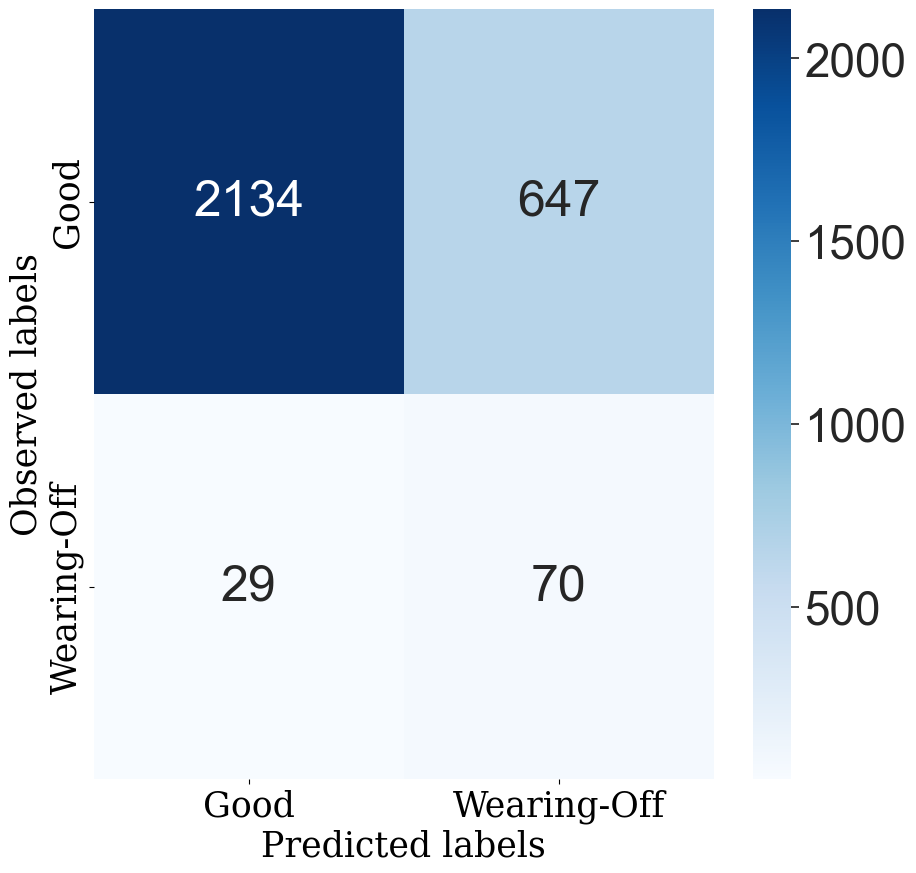

In [17]:
final_pipeline1 = Hyperpipe('5 - Final Pipeline CI GB',
                    outer_cv = StratifiedKFold(n_splits=5, shuffle=False),
                    inner_cv = StratifiedKFold(n_splits=3, shuffle=False),
                    use_test_set = True,
                    metrics = list(metrics.keys()),
                    best_config_metric='balanced_accuracy',
                    optimizer='sk_opt',
                    optimizer_params={'n_configurations': 30},
                    project_folder=f'./analysis/{dataset_type}{user}_{frequency}',
                    cache_folder=f'./cache/{dataset_type}{user}_{frequency}/',
                    verbosity=1,
                    performance_constraints=[MinimumPerformanceConstraint('balanced_accuracy', 0.75, 'mean')])

tested_methods = Categorical(['RandomUnderSampler', 'RandomOverSampler', 'SMOTE', 'BorderlineSMOTE'])
final_pipeline1 += PipelineElement('ImbalancedDataTransformer',
                           hyperparameters={ 'method_name': tested_methods })

final_pipeline1 += PipelineElement('GradientBoostingClassifier', 
                            hyperparameters={
                                'loss': ['deviance', 'exponential'],
                                'learning_rate': FloatRange(0.001, 1, 'logspace')
                            }, random_state=4)

# Fit hyperpipe
final_pipeline1.fit(X, y)

# Show learning algorithms mean validation results
# print("Comparison on learning algorithms on validation set")
# print(final_pipeline1.results_handler.get_mean_of_best_validation_configs_per_estimator())

# # Show feature importances
# print_feature_importances(final_pipeline1)

# # View CV splits for debugging
# for k,v in final_pipeline1.cross_validation.outer_folds.items():
#     print(v.train_indices)
#     print(v.test_indices)
#     print(len(v.train_indices), len(v.test_indices))
#     print()

# Write other reports to summary file
add_other_report_to_summary(final_pipeline1, with_estimator_comparison=False)

# Show confusion matrix
plot_confusion_matrix_from_pipeline(final_pipeline1)


In [18]:
# Alternative 1: Built-in Feature Importances (Fastest)
print("Method 1: Built-in GradientBoosting Feature Importances")
print("-" * 55)
try:
    # Get the trained estimator
    gb_estimator = final_pipeline1.optimum_pipe.named_steps['GradientBoostingClassifier']
    
    if hasattr(gb_estimator, 'feature_importances_'):
        importances = gb_estimator.feature_importances_
        feature_names = np.array(columns[1:-1])
        
        # Sort by importance
        indices = np.argsort(importances)[::-1]
        
        for i, idx in enumerate(indices):
            print(f"{feature_names[idx]:<20} {importances[idx]:.4f}")
    else:
        print("Built-in feature importances not available")
        
except Exception as e:
    print(f"Error: {e}")

print("\n" + "="*60 + "\n")


Method 1: Built-in GradientBoosting Feature Importances
-------------------------------------------------------
time_from_last_drug_taken 0.9415
heart_rate           0.0427
rem                  0.0113
steps                0.0043
stress_score         0.0001
total                0.0000
sleep_efficiency     0.0000
nonrem_percentage    0.0000
deep                 0.0000
light                0.0000
nonrem_total         0.0000
awake                0.0000




In [19]:
# Alternative 2: Using sklearn's permutation_importance directly
print("Method 2: Sklearn Permutation Importance")
print("-" * 40)
try:
    from sklearn.inspection import permutation_importance
    
    # Get the fitted pipeline
    fitted_pipeline = final_pipeline1.optimum_pipe
    
    # Use a subset of data for faster computation (optional)
    # X_sample = X.sample(n=min(1000, len(X)), random_state=42)
    # y_sample = y.loc[X_sample.index]
    
    # Calculate permutation importance
    perm_importance = permutation_importance(
        fitted_pipeline, X, y, 
        n_repeats=10,  # Reduced for speed
        random_state=42,
        scoring='balanced_accuracy'
    )
    
    feature_names = np.array(columns[1:-1])
    
    # Sort by importance
    indices = np.argsort(perm_importance.importances_mean)[::-1]
    
    for i, idx in enumerate(indices):
        print(f"{feature_names[idx]:<20} {perm_importance.importances_mean[idx]:.4f} "
              f"±{perm_importance.importances_std[idx]:.4f}")
        
except Exception as e:
    print(f"Error: {e}")

print("\n" + "="*60 + "\n")



Method 2: Sklearn Permutation Importance
----------------------------------------
Error: 'PhotonPipeline' object has no attribute 'classes_'




In [20]:
# Alternative 3: SHAP Values (if you have shap installed)
print("Method 3: SHAP Feature Importance")
print("-" * 35)
try:
    import shap
    
    # Get the fitted pipeline
    fitted_pipeline = final_pipeline1.optimum_pipe
    
    # Use a sample for SHAP (it can be slow on large datasets)
    X_sample = X.sample(n=min(500, len(X)), random_state=42)
    
    # Create explainer
    explainer = shap.Explainer(fitted_pipeline, X_sample)
    shap_values = explainer(X_sample)
    
    # Get mean absolute SHAP values as feature importance
    feature_importance = np.abs(shap_values.values).mean(0)
    feature_names = np.array(columns[1:-1])
    
    # Sort by importance
    indices = np.argsort(feature_importance)[::-1]
    
    for i, idx in enumerate(indices):
        print(f"{feature_names[idx]:<20} {feature_importance[idx]:.4f}")
        
except ImportError:
    print("SHAP not installed. Install with: pip install shap")
except Exception as e:
    print(f"Error: {e}")

print("\n" + "="*60 + "\n")



Method 3: SHAP Feature Importance
-----------------------------------
Error: The passed model is not callable and cannot be analyzed directly with the given masker! Model: PhotonPipeline(elements=[('ImbalancedDataTransformer',
                          PipelineElement(config=None,
                                          method_name='BorderlineSMOTE',
                                          name='ImbalancedDataTransformer')),
                         ('GradientBoostingClassifier',
                          PipelineElement(ccp_alpha=0.0,
                                          criterion='friedman_mse', init=None,
                                          learning_rate=0.006301171989311478,
                                          loss='exponential', max_depth=3,
                                          max_features=None,
                                          max_leaf_nodes=None,
                                          min_impurity_decrease=0.0,
                             

In [21]:
# Alternative 4: Simple DataFrame approach for better visualization
print("Method 4: DataFrame Summary")
print("-" * 25)
try:
    import pandas as pd
    
    # Using the original hyperpipe method but organizing results better
    r = final_pipeline1.get_permutation_feature_importances(
        n_repeats=20,  # Reduced for speed
        random_state=0, 
        scoring='balanced_accuracy'
    )
    
    # Create DataFrame for better organization
    importance_df = pd.DataFrame({
        'Feature': np.array(columns[1:-1]),
        'Importance': r["mean"],
        'Std_Dev': r["std"],
        'Lower_Bound': r["mean"] - 2 * r["std"],
        'Upper_Bound': r["mean"] + 2 * r["std"]
    })
    
    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # Display top 10
    print("Top 10 Most Important Features:")
    print(importance_df.head(10).to_string(index=False, float_format='%.4f'))
    
    # Show only statistically significant features
    significant_features = importance_df[importance_df['Lower_Bound'] > 0]
    
    if len(significant_features) > 0:
        print(f"\nStatistically Significant Features ({len(significant_features)}):")
        print(significant_features.to_string(index=False, float_format='%.4f'))
    else:
        print("\nNo statistically significant features found")
        
except Exception as e:
    print(f"Error: {e}")

print("\n" + "="*60 + "\n")



Method 4: DataFrame Summary
-------------------------

Computing permutation importances. This may take a while.
*****************************************************************************************************
Permutation Importances: Fitting model for outer fold 1
Permutation Importances: Calculating performances for outer fold 1
Error: 'PhotonPipeline' object has no attribute 'classes_'




In [22]:
# Alternative 5: Quick and Simple (Minimal Code)
print("Method 5: Quick and Simple")
print("-" * 25)
try:
    # Just get the built-in importances with minimal code
    estimator = final_pipeline1.optimum_pipe.named_steps['GradientBoostingClassifier']
    importances = estimator.feature_importances_
    features = np.array(columns[1:-1])
    
    # Create sorted list of (importance, feature) tuples
    sorted_features = sorted(zip(importances, features), reverse=True)
    
    print("Feature Importance Ranking:")
    for i, (importance, feature) in enumerate(sorted_features[:15], 1):
        print(f"{i:2d}. {feature:<20} {importance:.4f}")
        
except Exception as e:
    print(f"Error: {e}")

Method 5: Quick and Simple
-------------------------
Feature Importance Ranking:
 1. time_from_last_drug_taken 0.8545
 2. steps                0.0469
 3. stress_score         0.0356
 4. light                0.0253
 5. heart_rate           0.0189
 6. nonrem_total         0.0104
 7. rem                  0.0075
 8. deep                 0.0004
 9. total                0.0004
10. awake                0.0001
11. sleep_efficiency     0.0000
12. nonrem_percentage    0.0000
